In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import DataLoader 
import io 
import torch.nn.functional as F 
import sys 
from datasets import get_dataset 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH, COLORS 
from model_builder import get_pretrained_model_v2 
from configuration import Configuration 
from models.classifier import LinearProbe 

DATASET = "synaptic-semantic-segmentation"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_channels = 3 if "imagenet" in WEIGHTS.lower() else 1

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model

In [3]:
model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0, 
    pretrained=True if n_channels == 3 else False,
    in_channels=n_channels,
    as_classifier=True,
    blocks="all",
    global_pool="patch",
    num_classes=4
)
model.to(DEVICE)
model.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
global_pool patch
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


### Load and embed dataset 

In [24]:
from collections import defaultdict
_, _, test_dataset = get_dataset(name=DATASET, cfg=cfg)
P = 16

embeddings, ground_truths, images = [], [], []
perforated_indices = []
perforated_embeddings = defaultdict(list)
perforated_coords = defaultdict(list)
with torch.no_grad():
    for idx in range(len(test_dataset)):
        batch = test_dataset[idx]
        X, y = batch
        X = X.unsqueeze(0).to(DEVICE)
        pred = model.forward_features(X)
        embeddings.append(pred.squeeze(0).cpu().numpy())
        img = X.squeeze().cpu().numpy()
        ground_truths.append(y.data.cpu().numpy()) 
        images.append(img)
        perf_mask = y[2].data.cpu().numpy()
        if np.count_nonzero(perf_mask) > 0:
            perforated_indices.append(idx)
            ys = np.arange(0, img.shape[0], P)
            xs = np.arange(0, img.shape[1], P)
            p_counter = 0
            for j in ys:
                for i in xs:
                    m = perf_mask[j:j+P, i:i+P]
                    if np.count_nonzero(m) > 0:
                        perforated_coords[idx].append((j, i))
                        patch = img[j:j+P, i:i+P]
                        perforated_embeddings[idx].append(embeddings[0][p_counter])
                        p_counter += 1

        

embeddings = np.concatenate(embeddings, axis=0)
ground_truths = np.array(ground_truths)
images = np.array(images) if "imagenet" in WEIGHTS.lower() else np.concatenate(images, axis=0)
n_images = images.shape[0]

print(embeddings.shape, ground_truths.shape, images.shape)

100%|██████████| 1357/1357 [00:00<00:00, 2390.87it/s]


Train dataset size: 1191
Valid dataset size: 354
Test dataset size: 375
(73500, 384) (375, 4, 224, 224) (84000, 224)


66 66 66


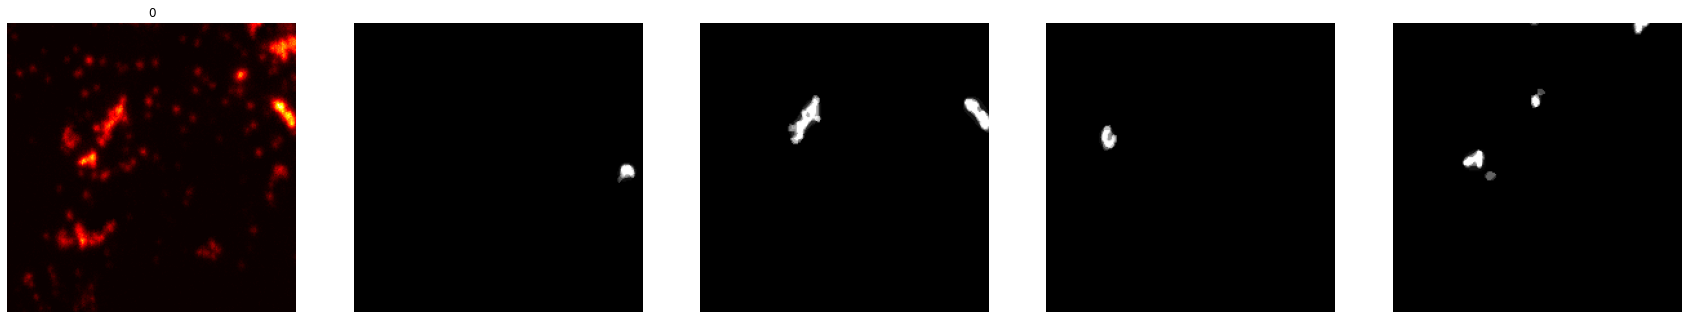

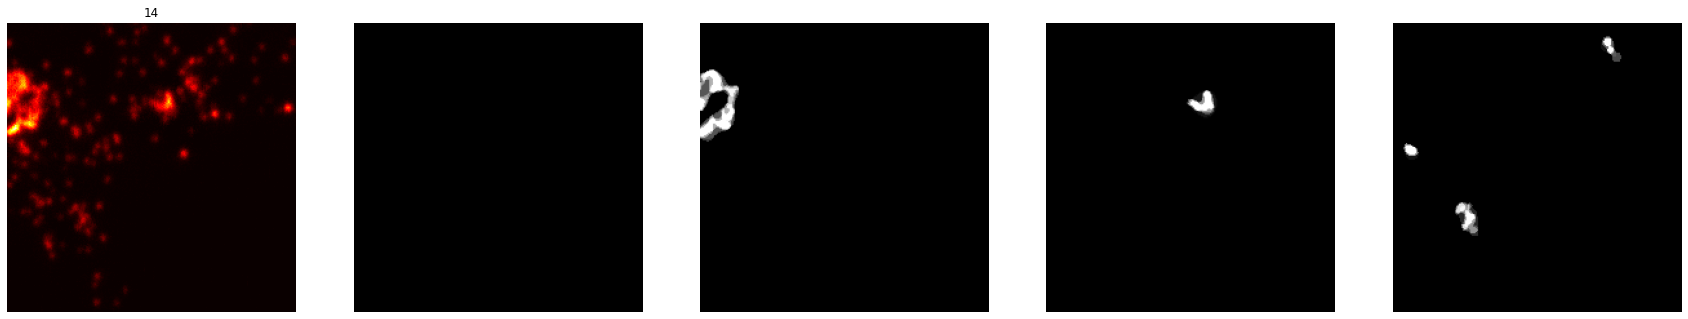

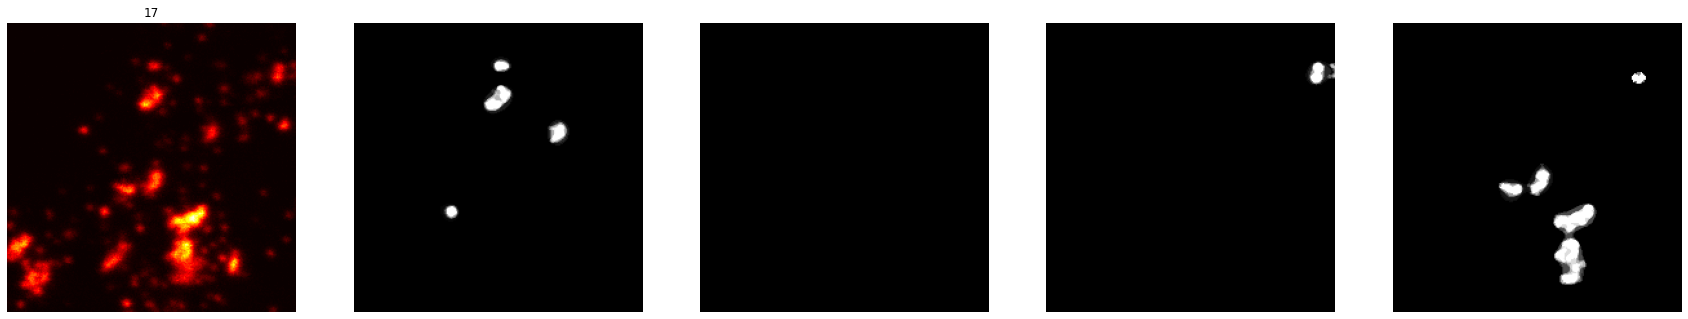

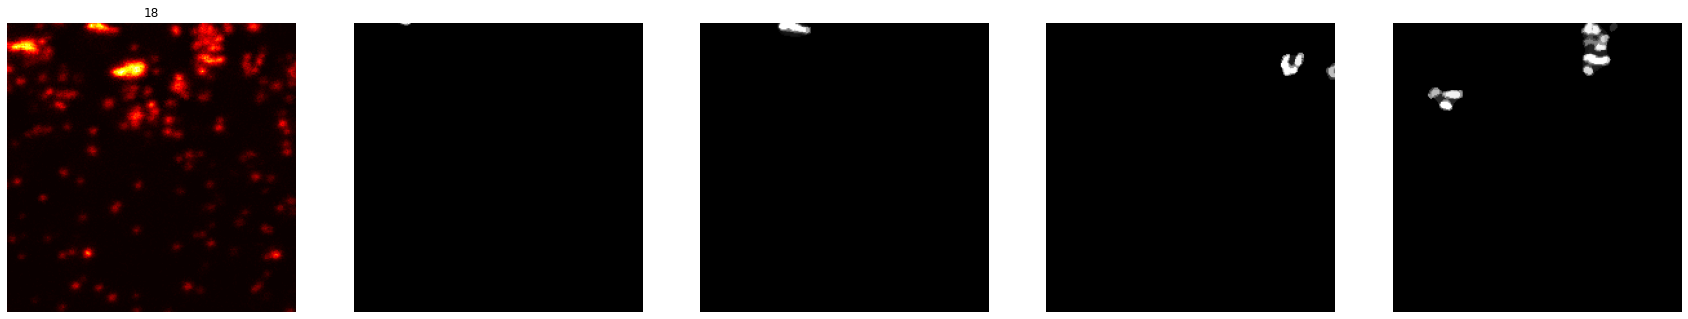

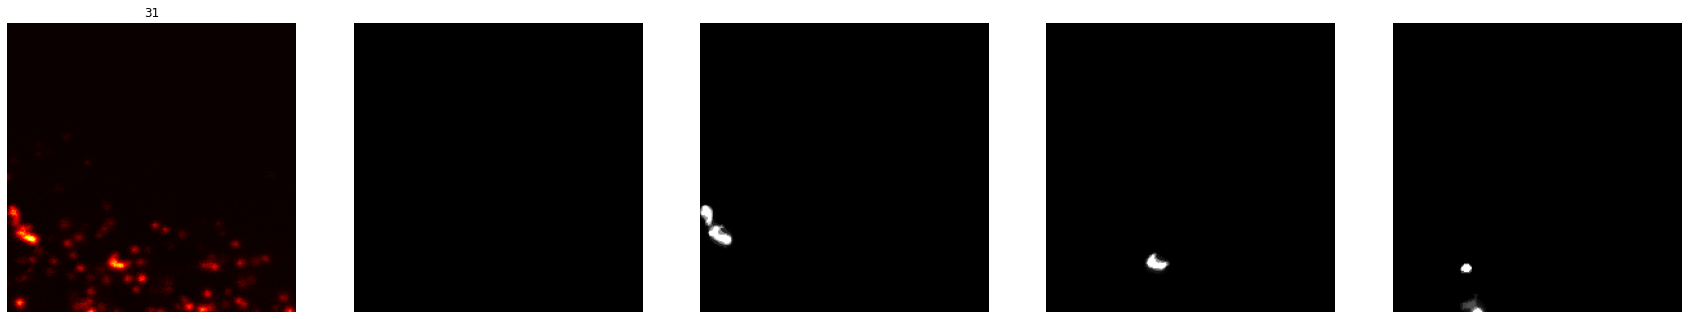

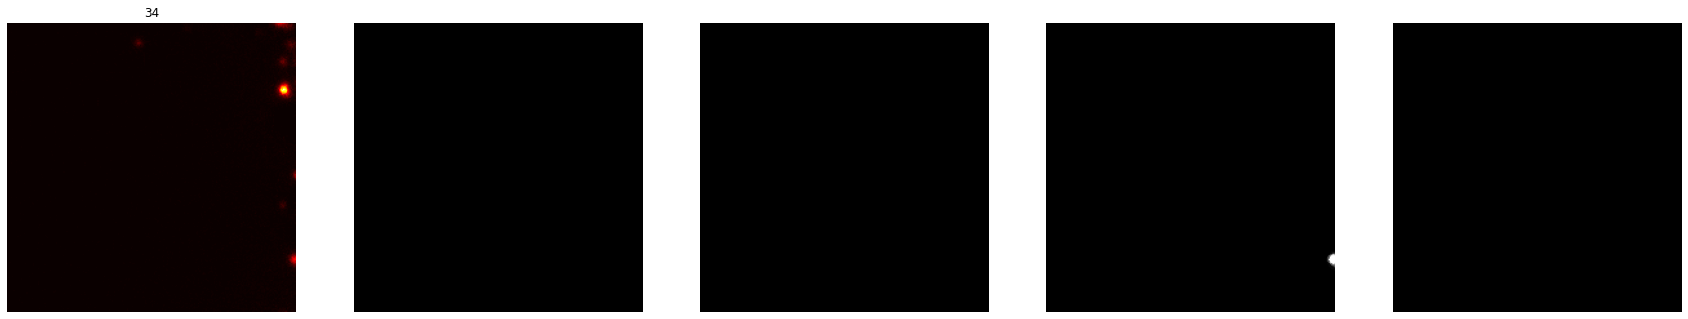

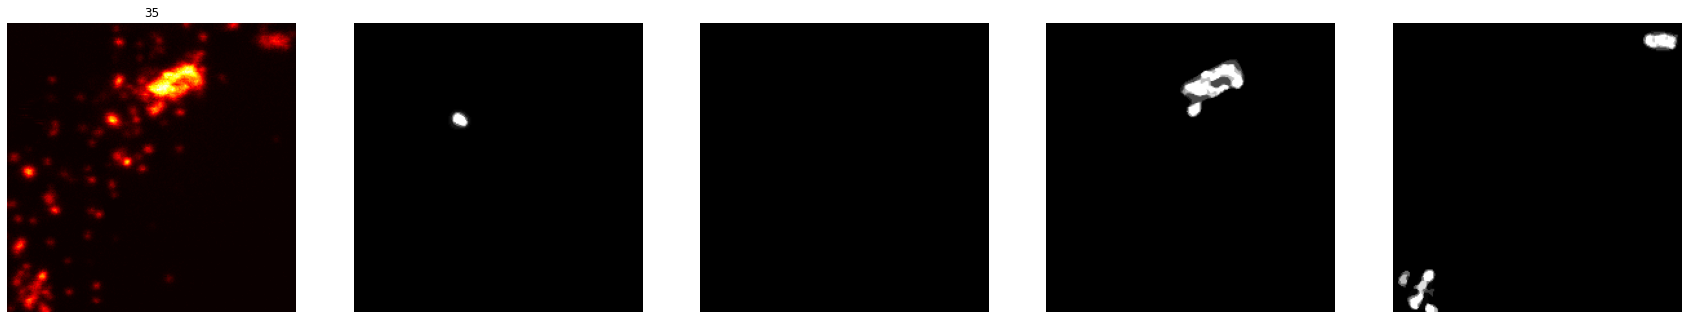

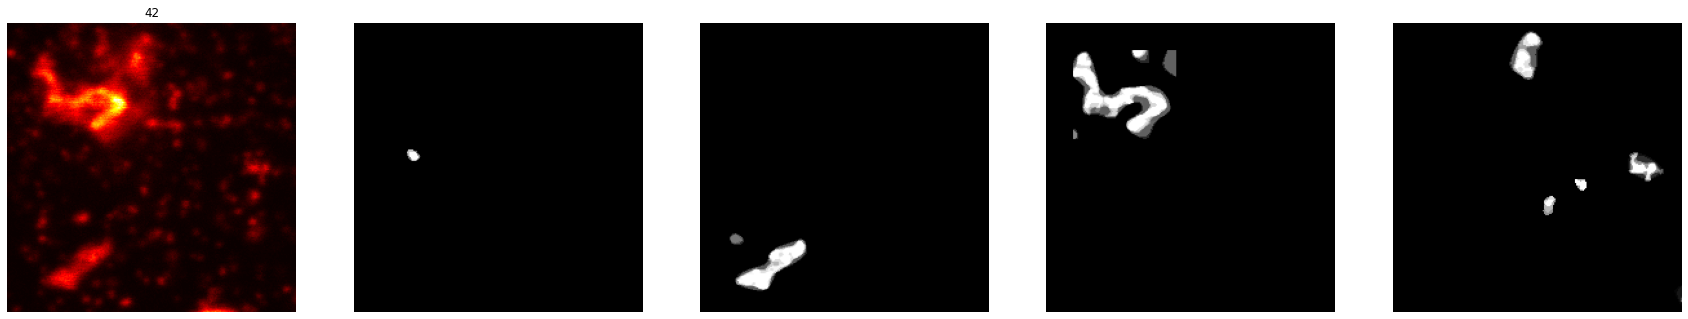

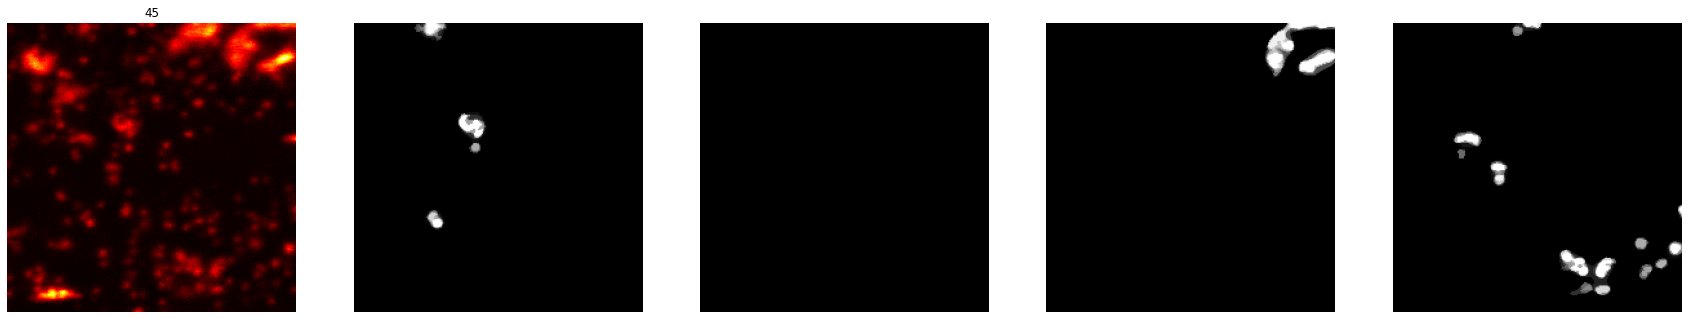

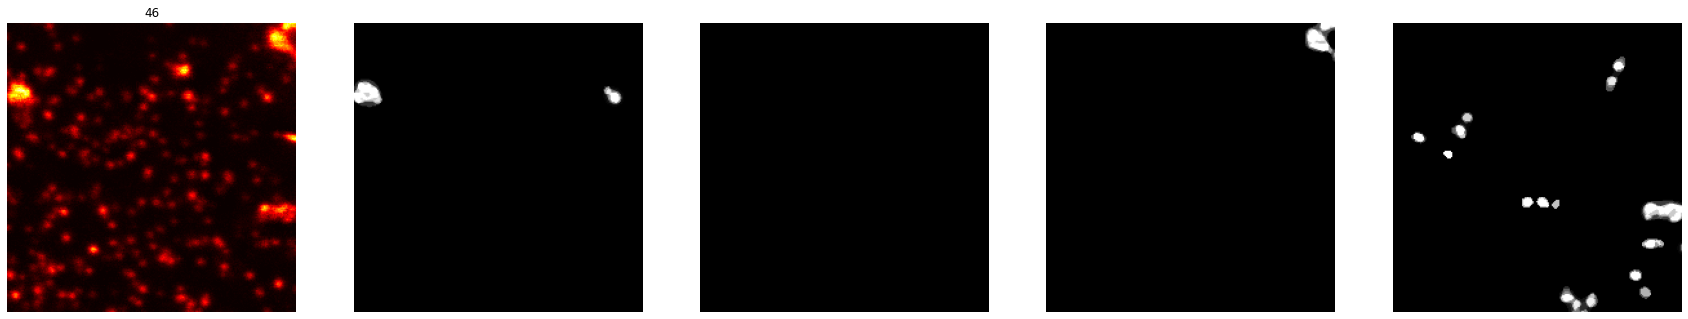

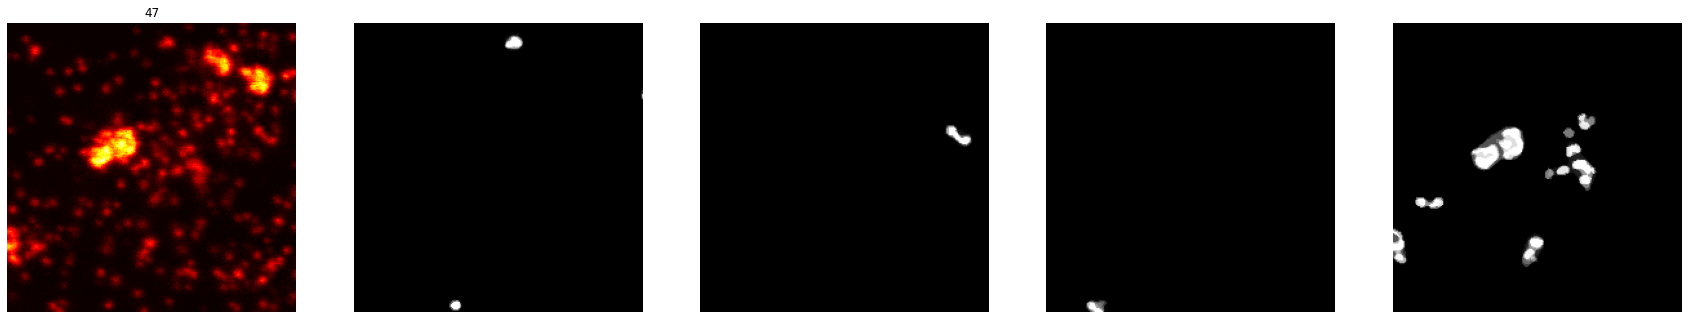

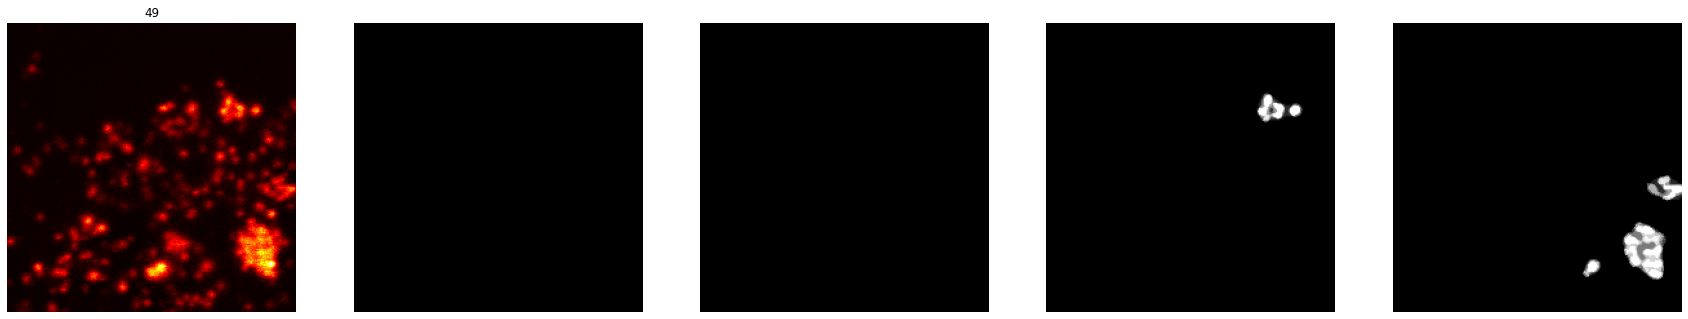

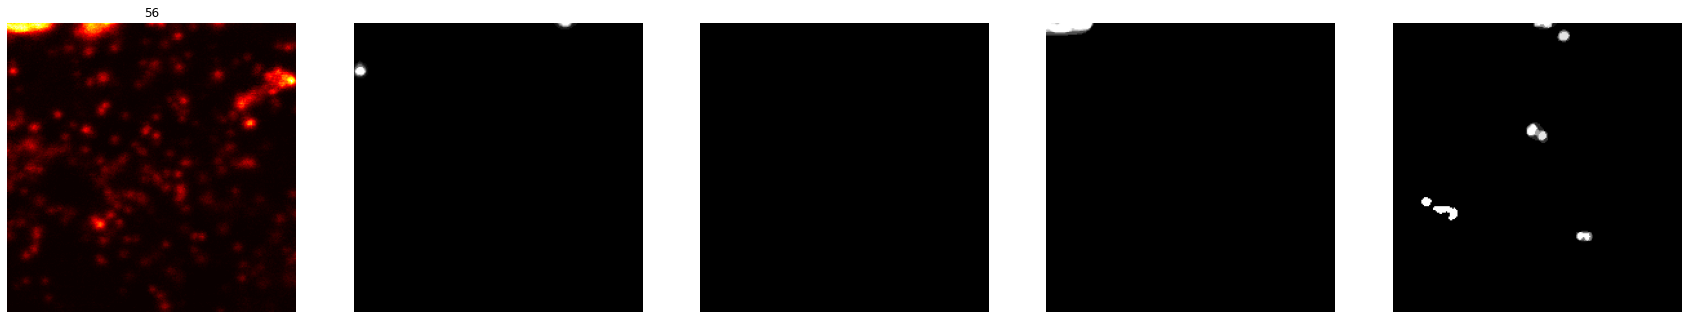

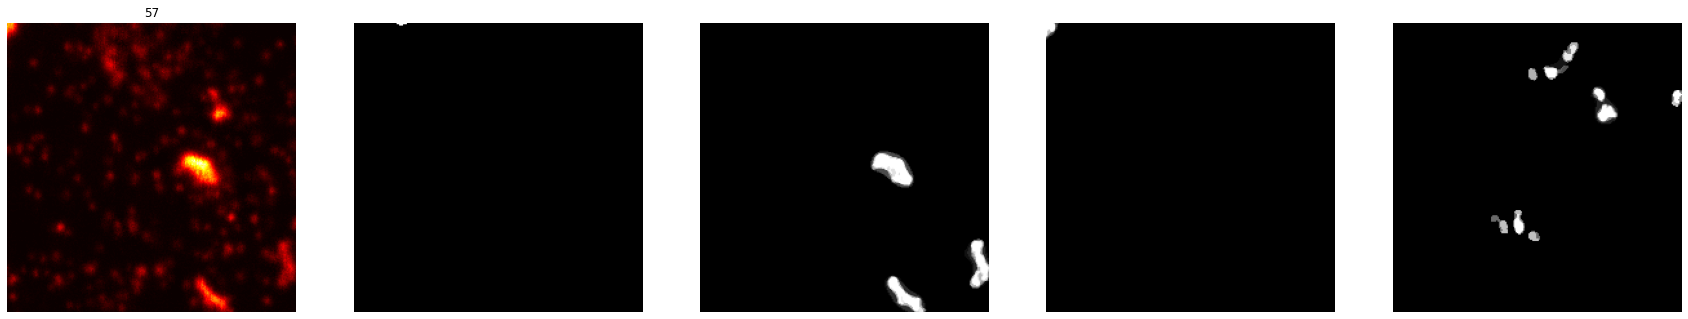

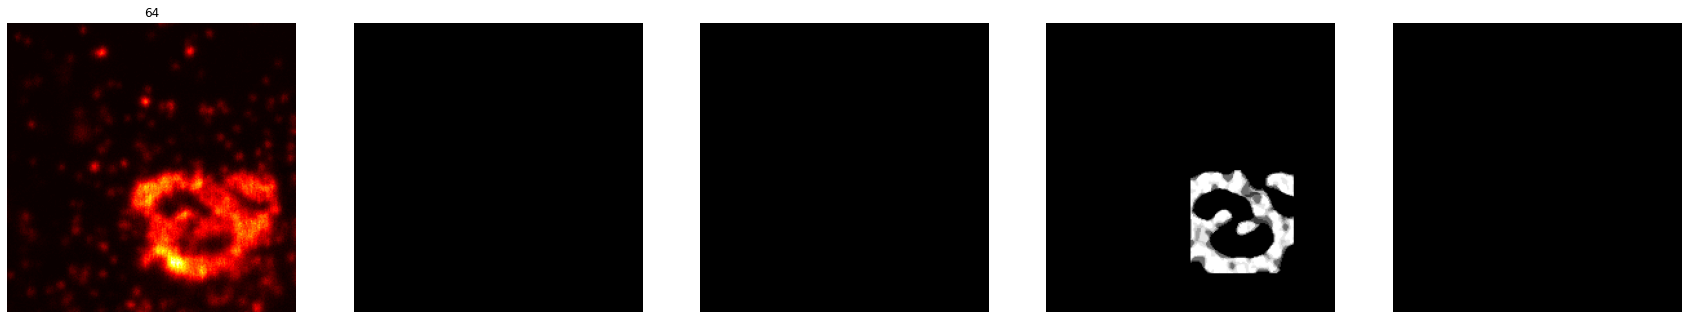

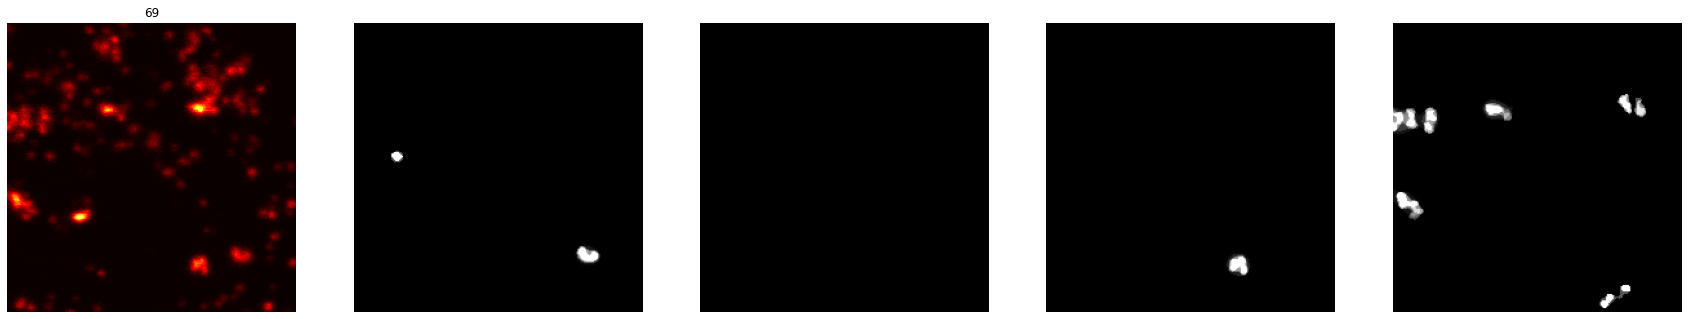

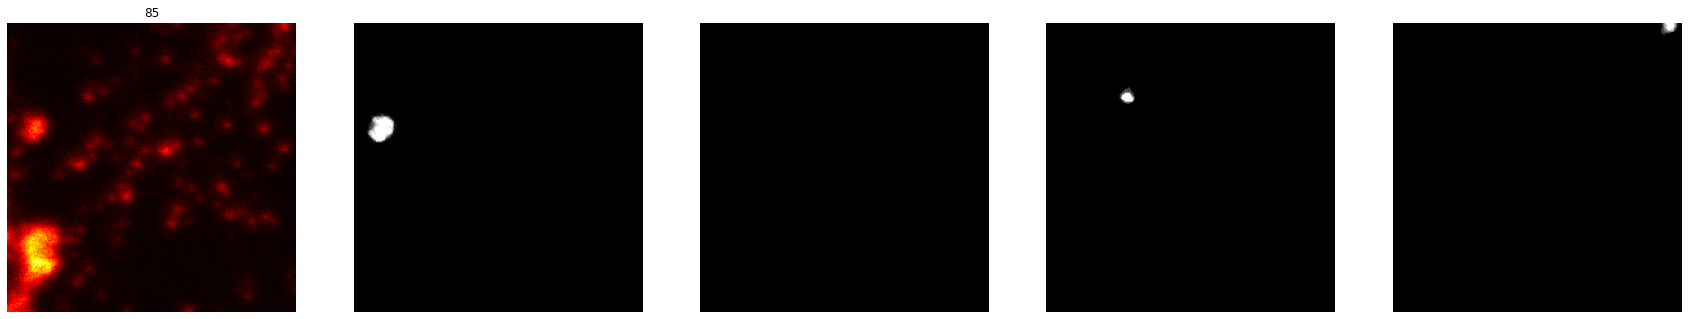

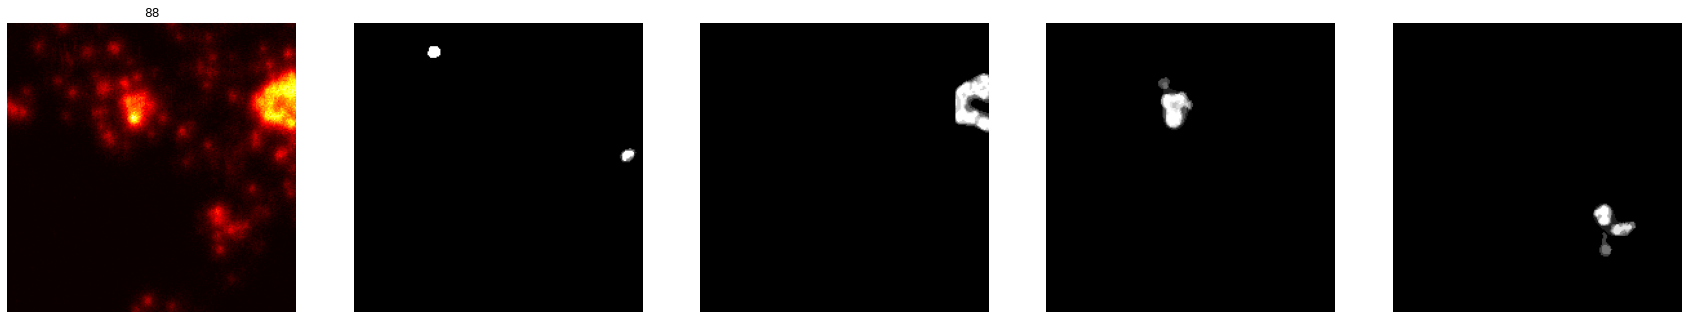

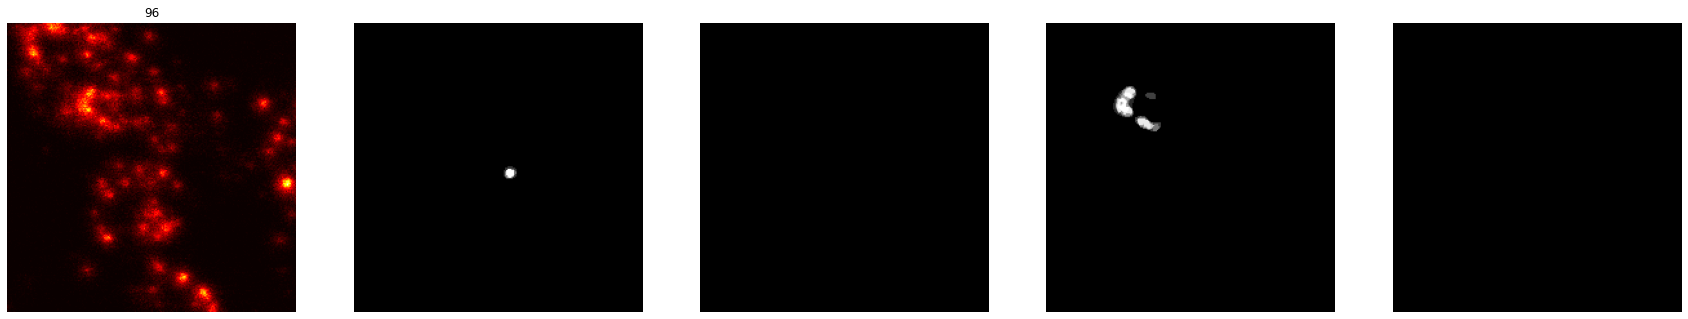

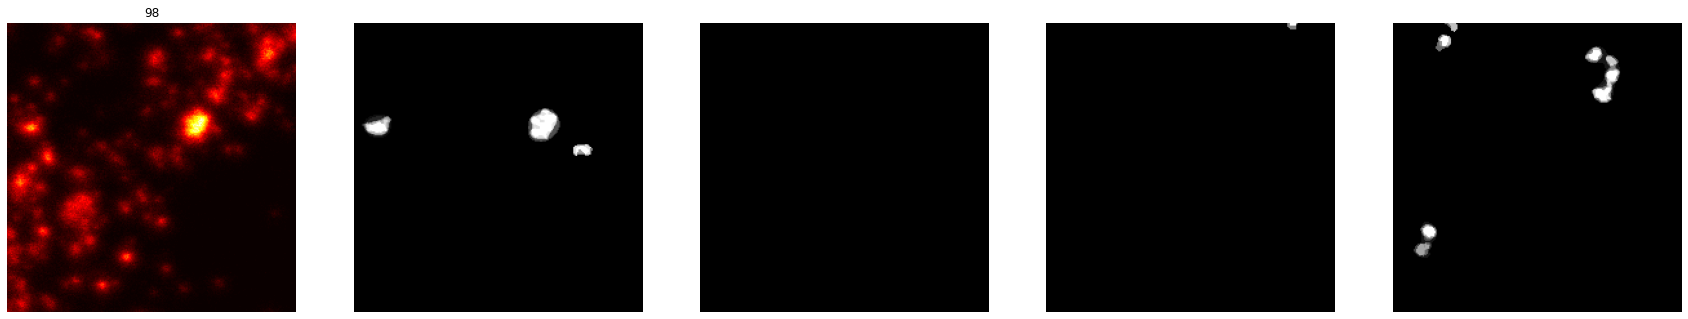

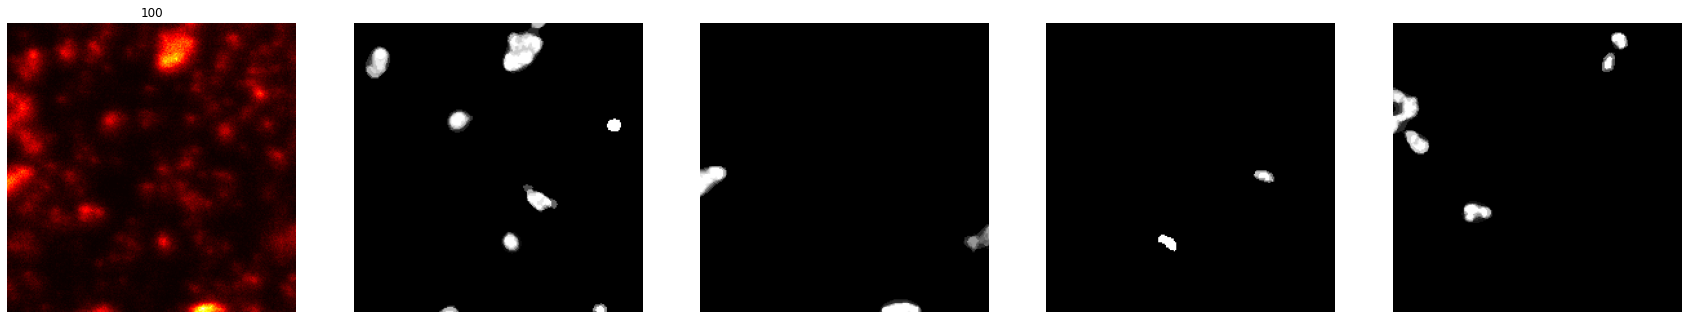

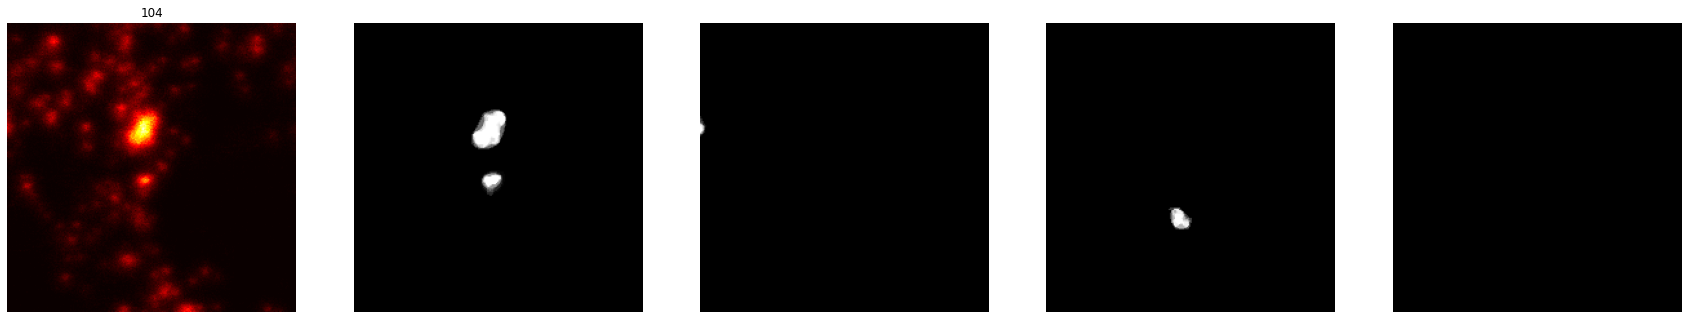

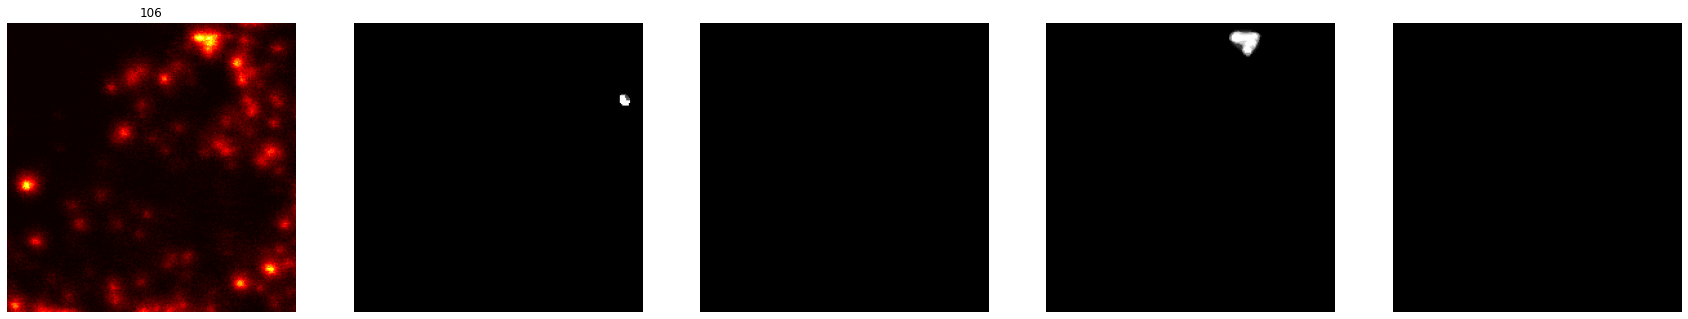

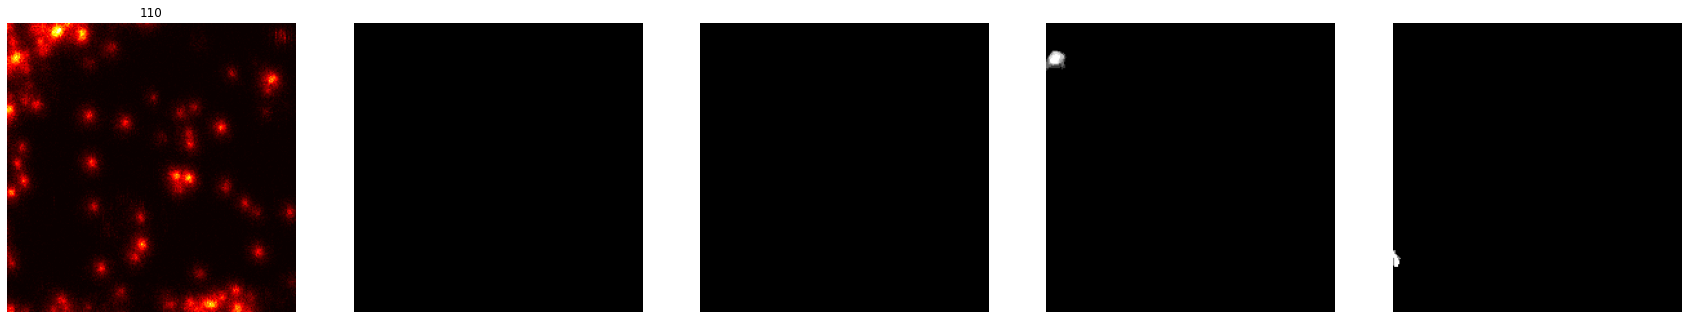

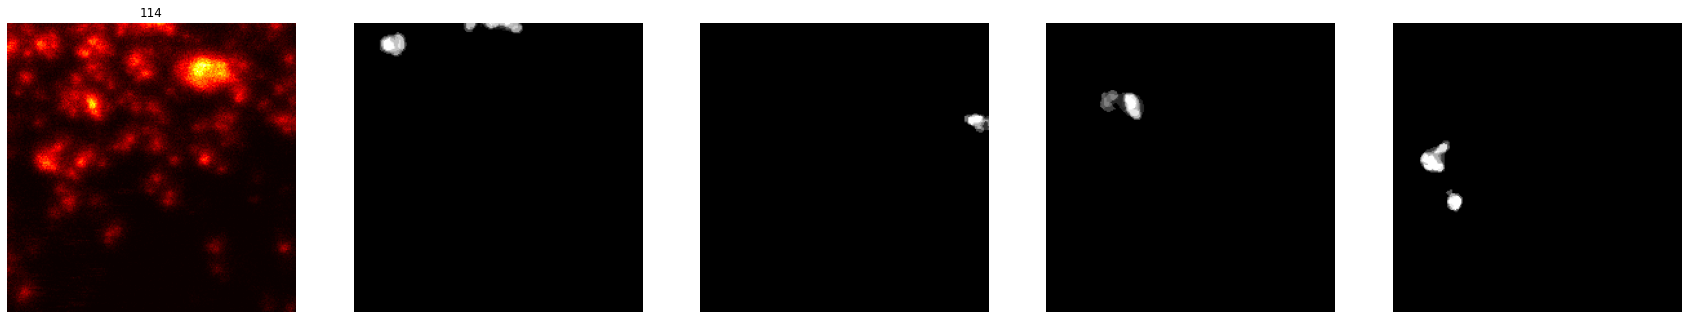

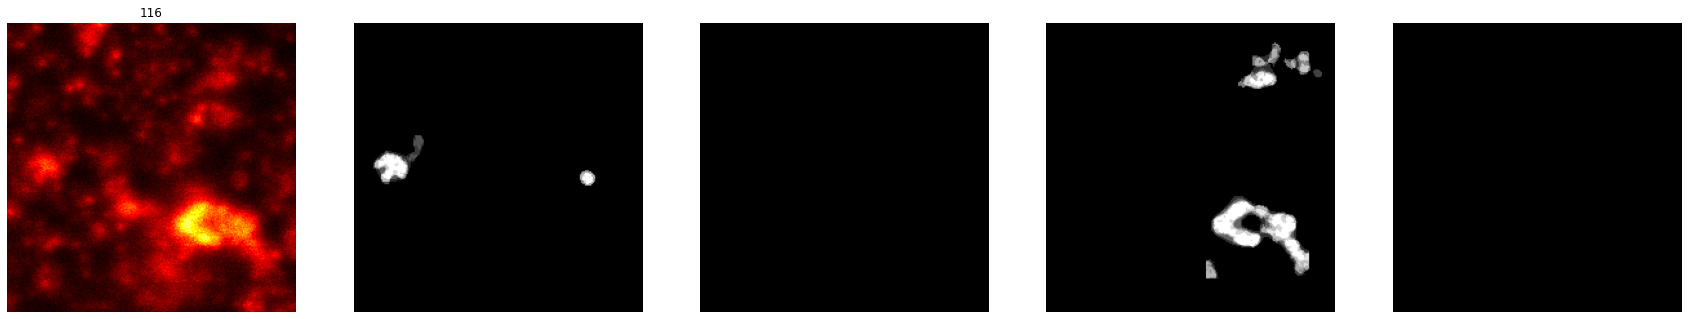

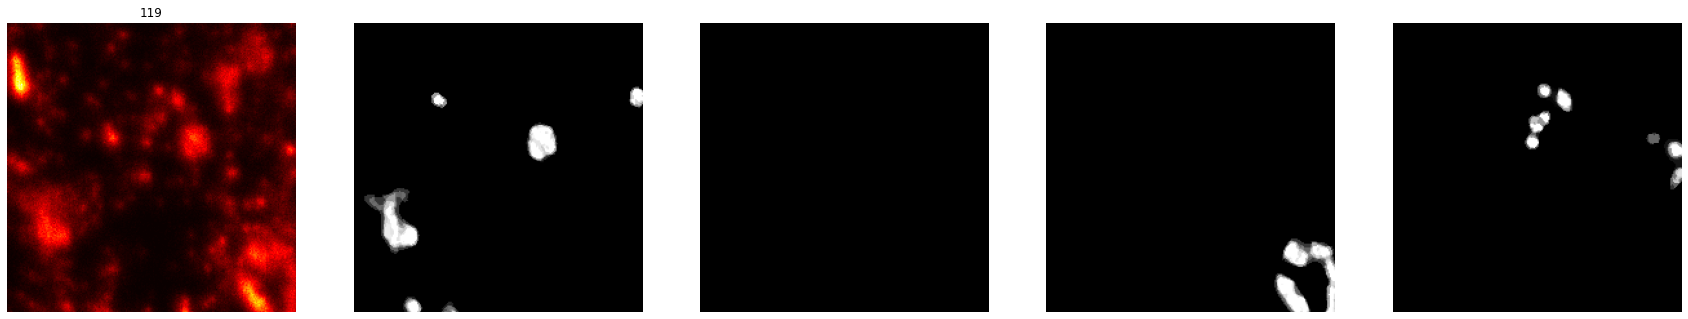

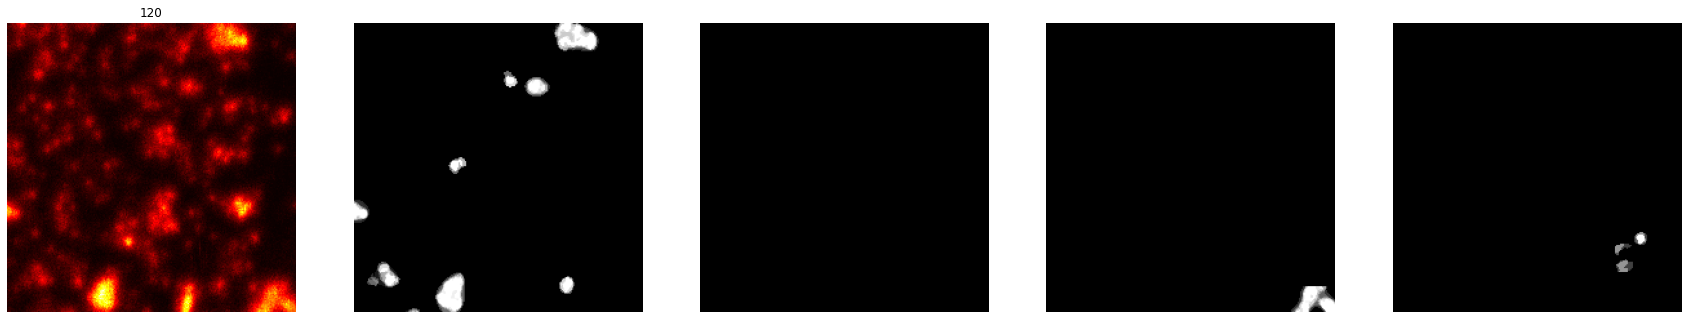

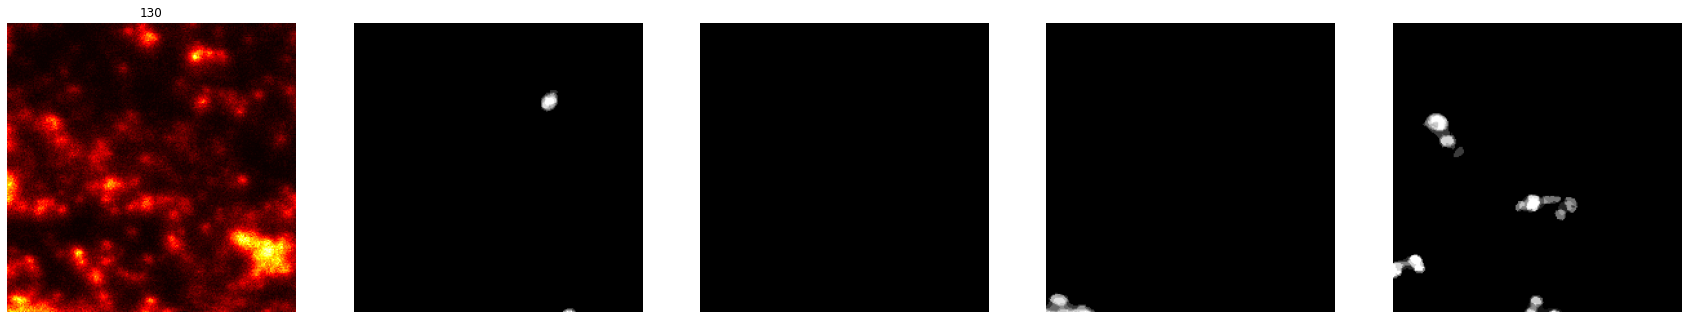

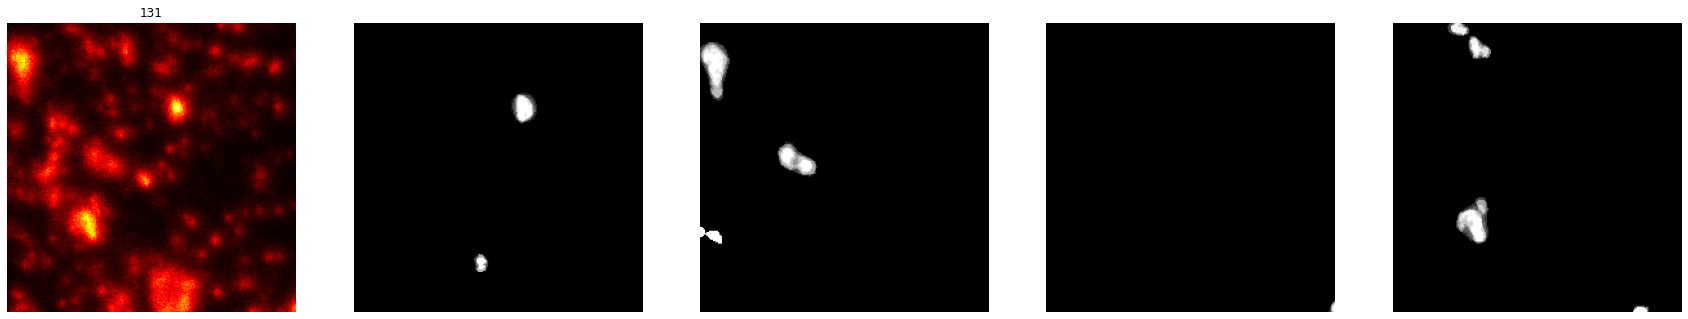

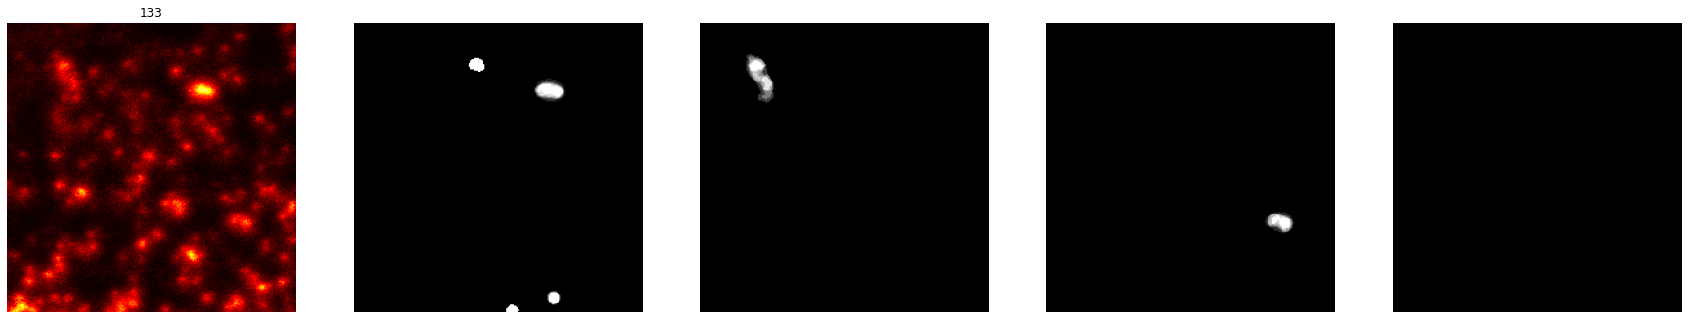

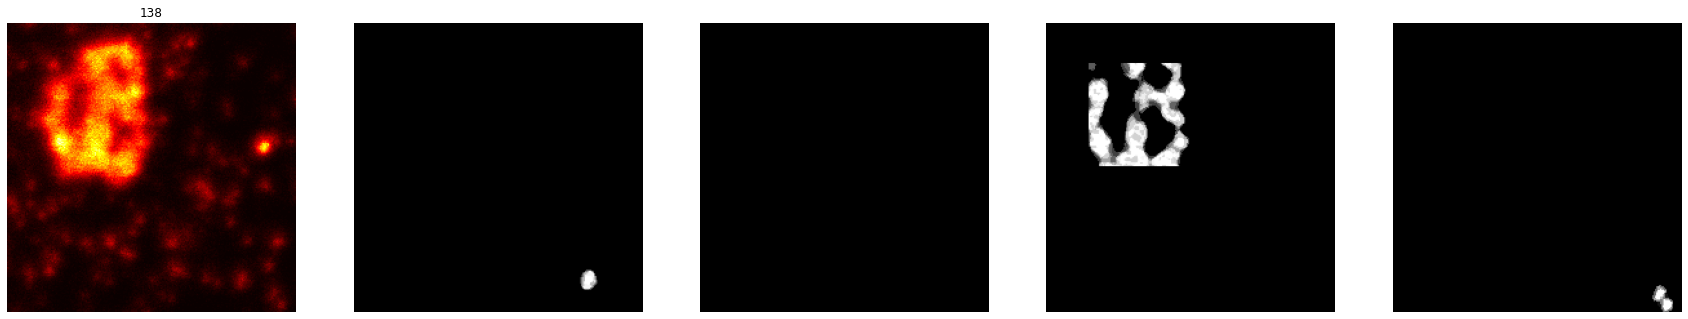

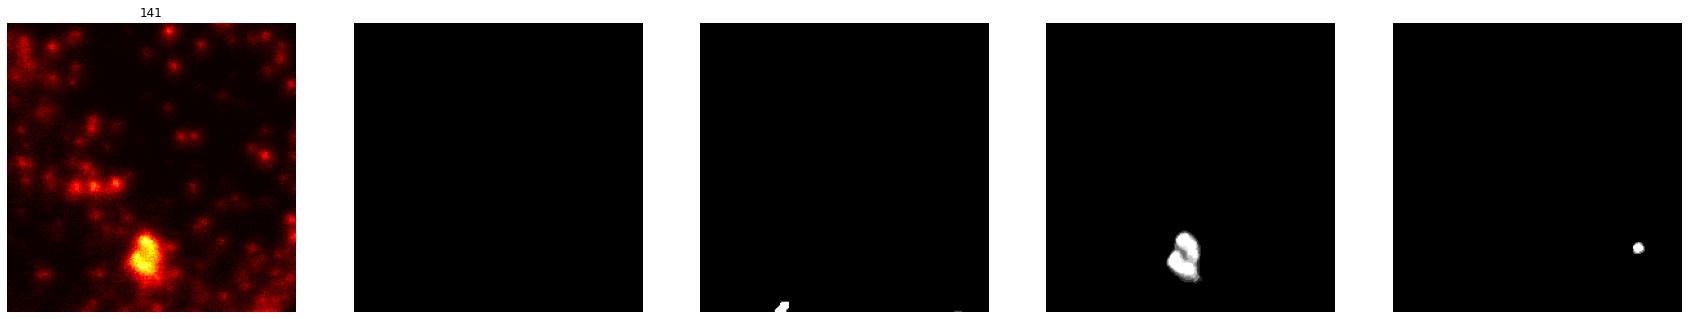

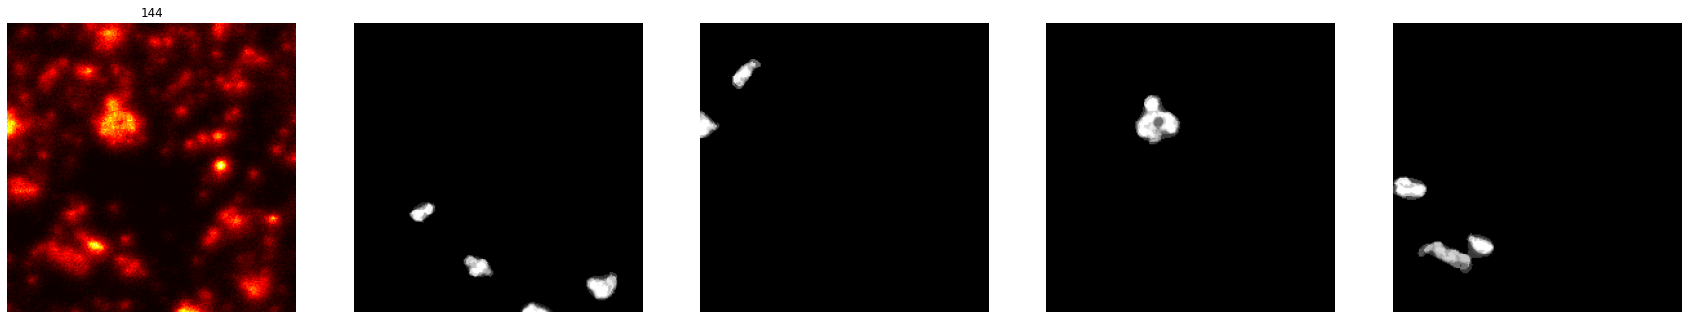

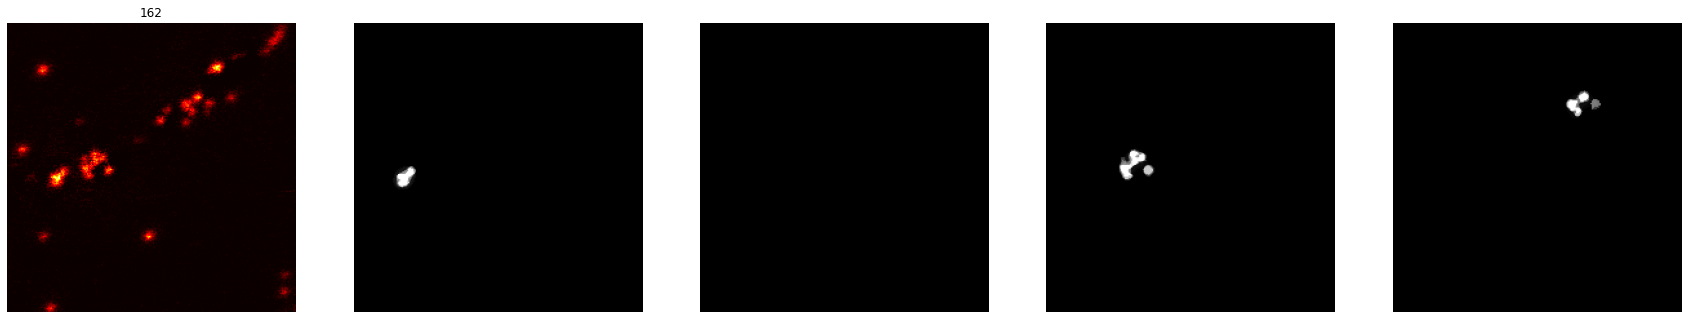

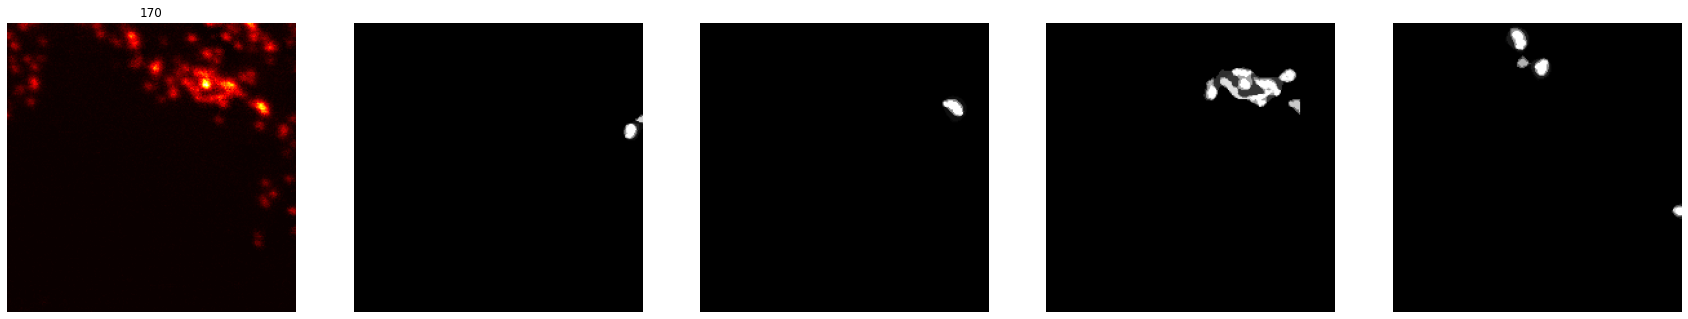

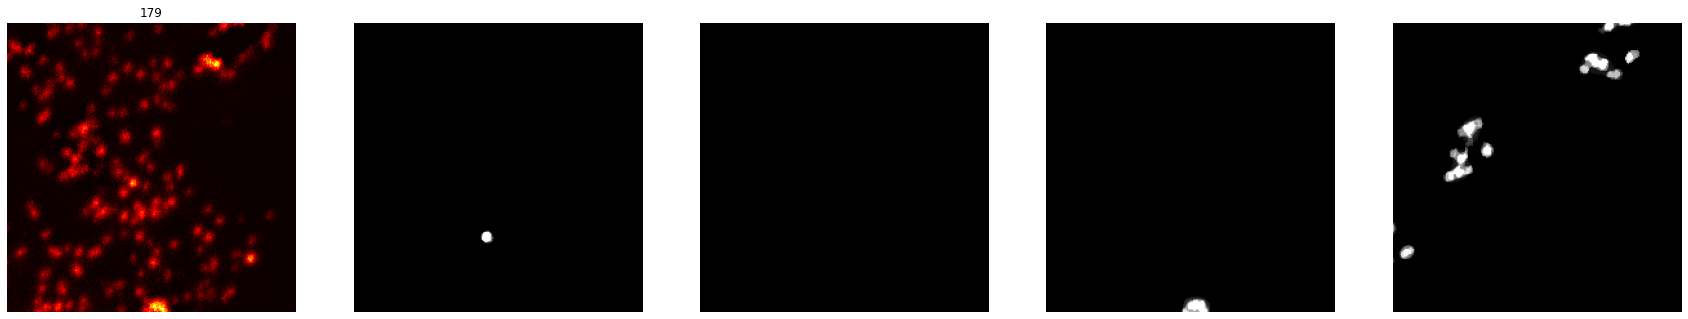

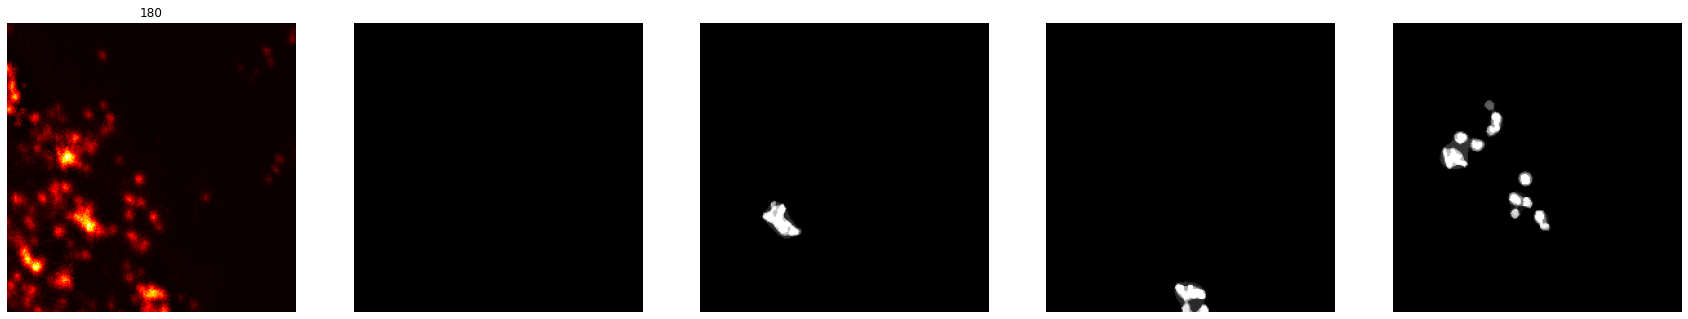

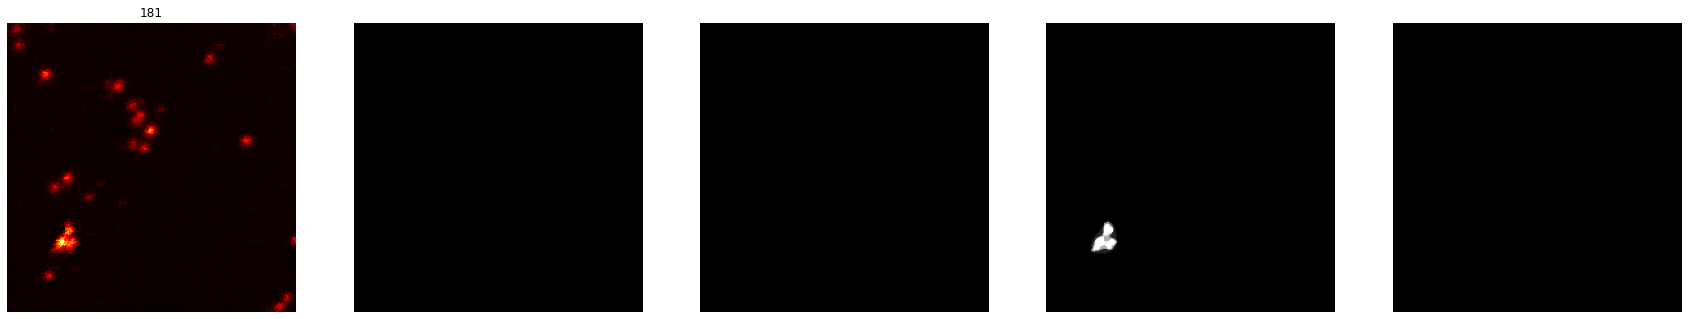

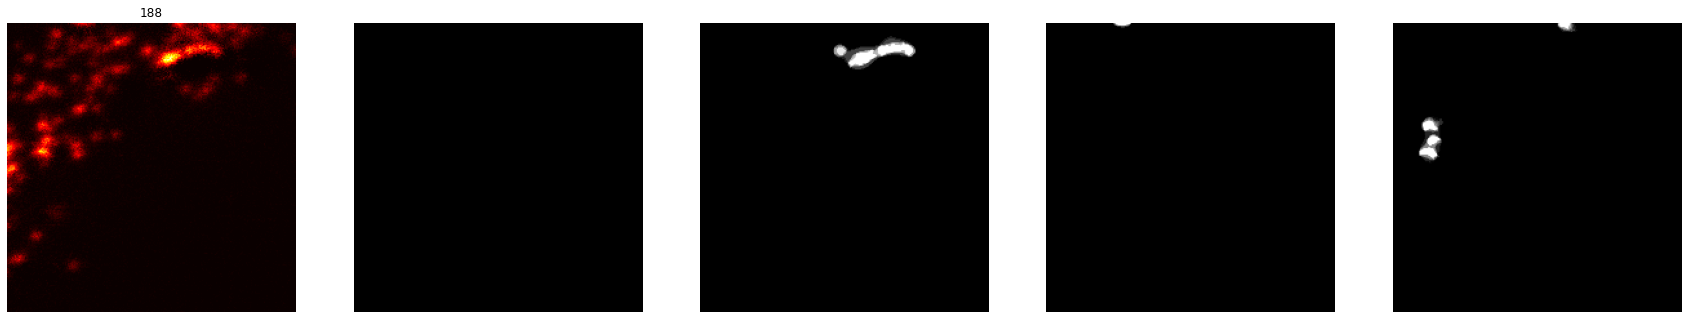

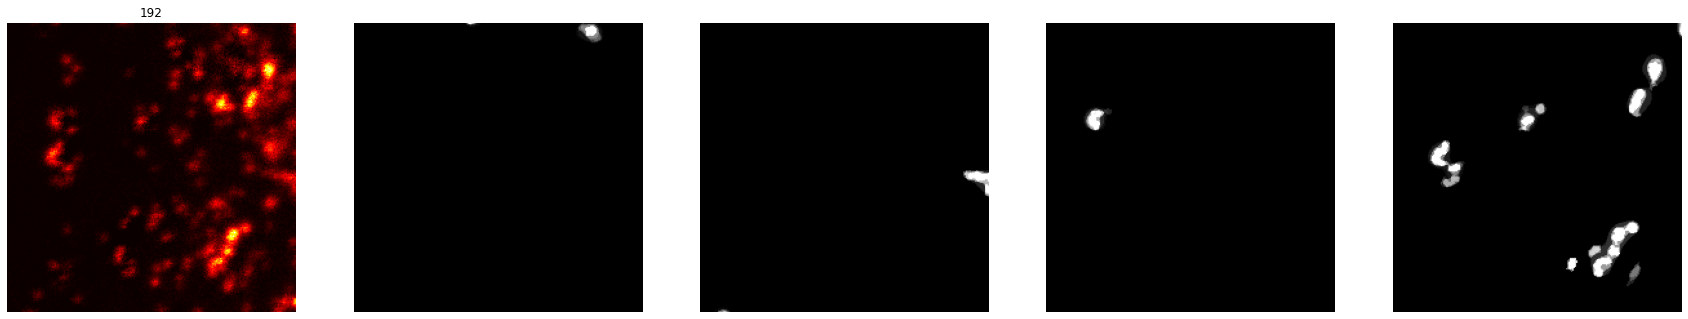

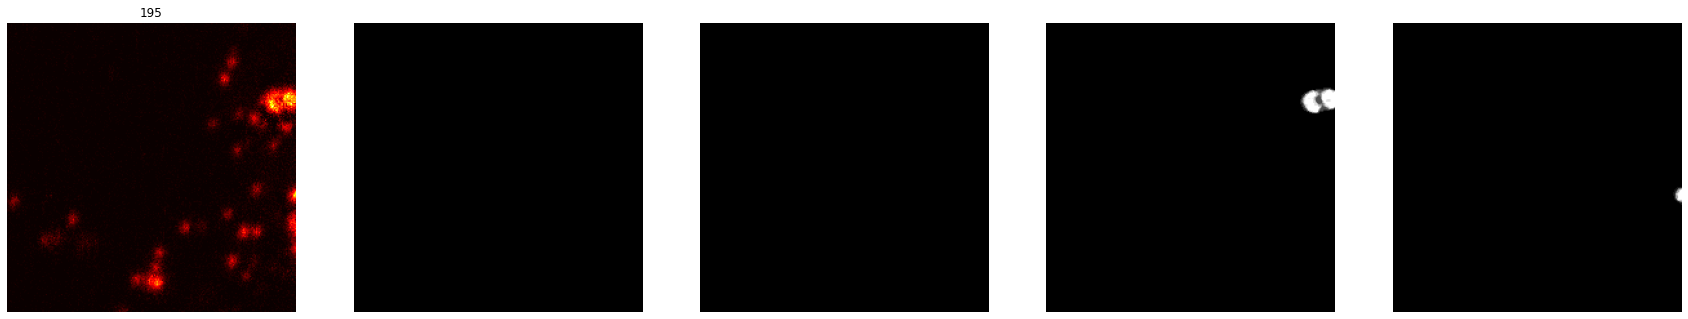

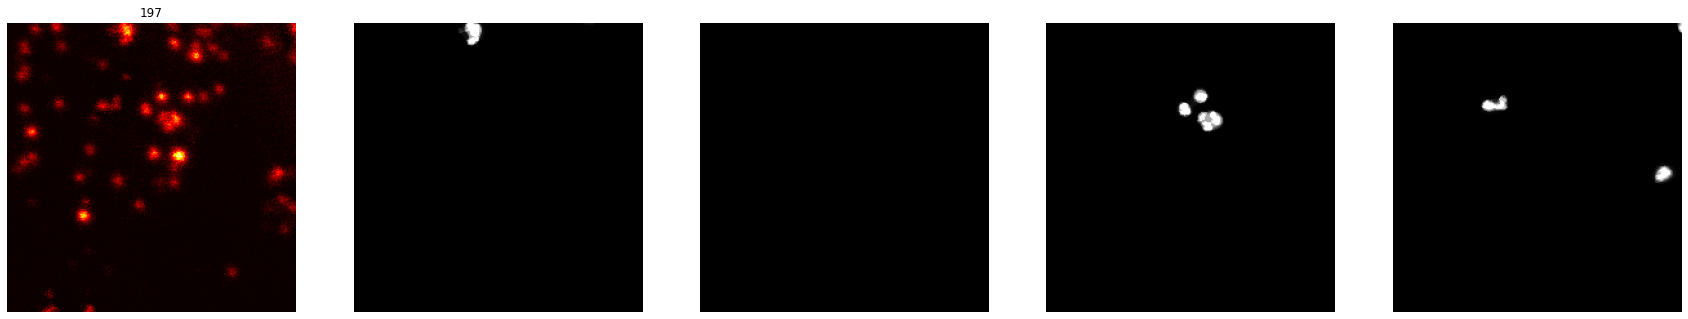

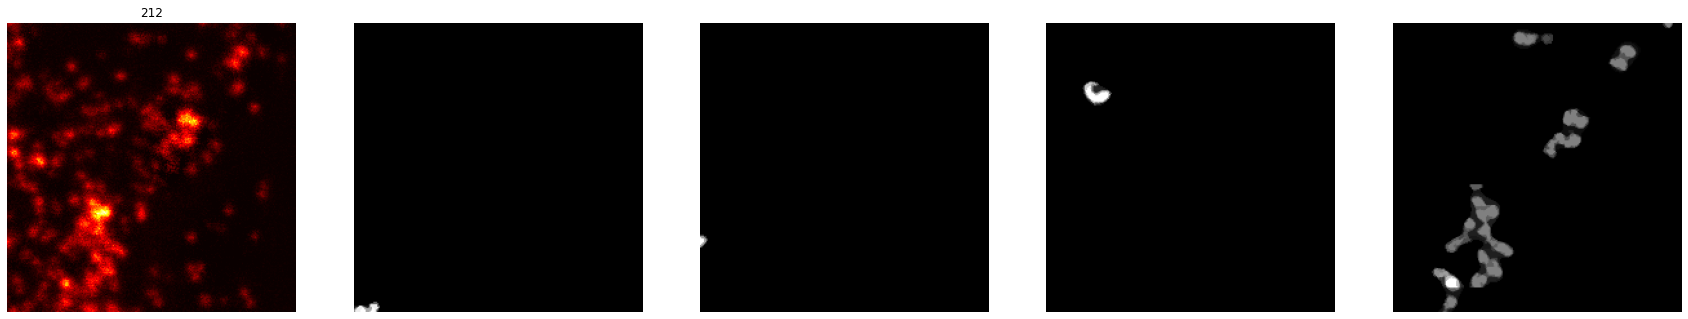

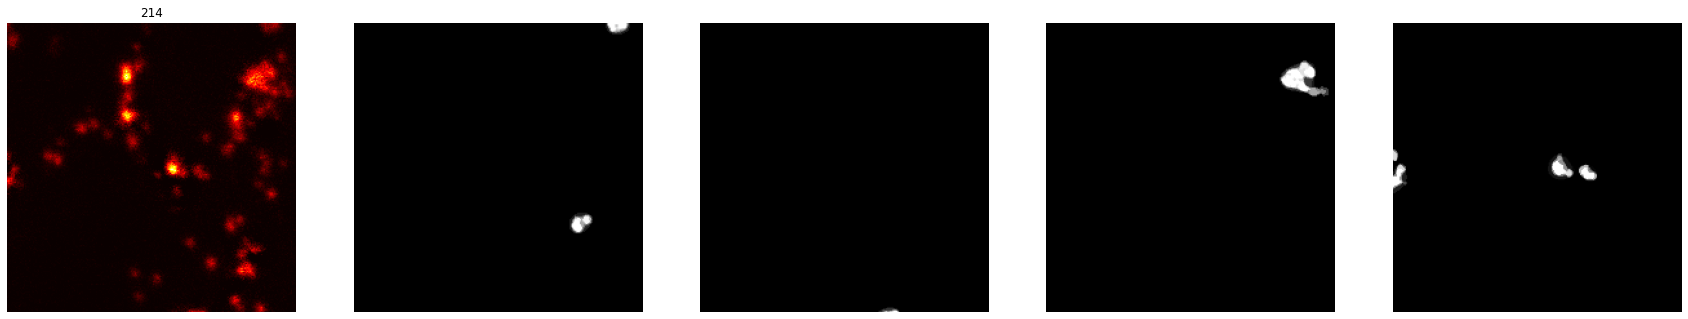

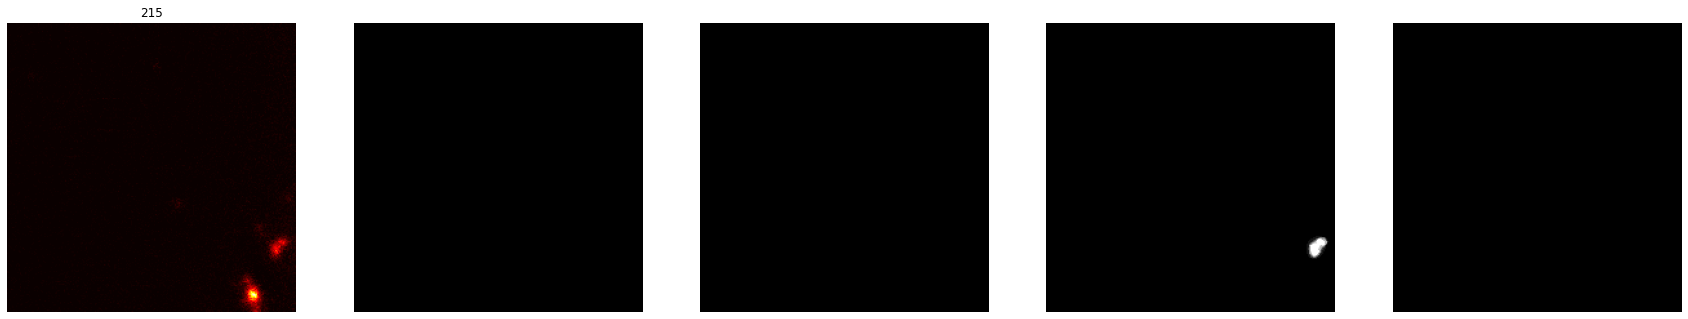

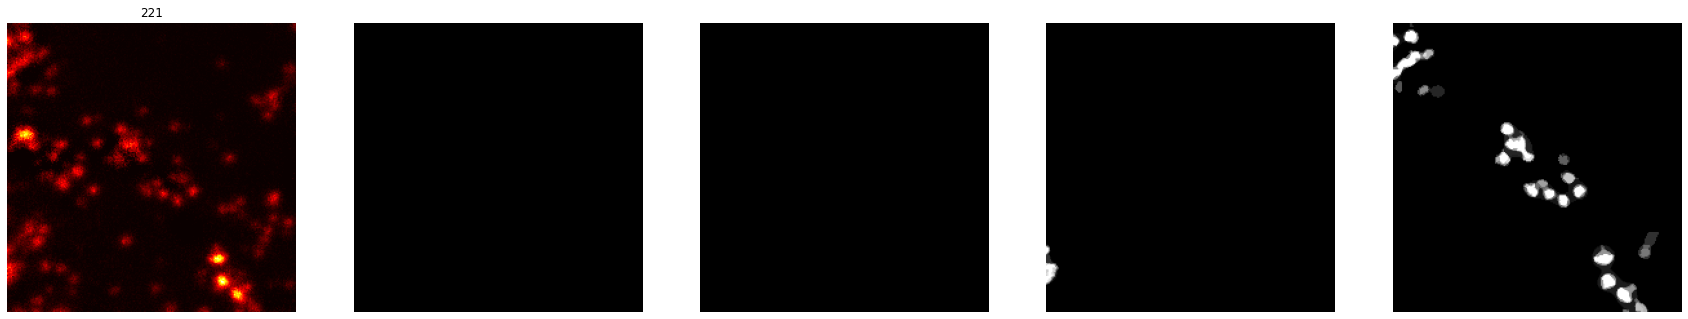

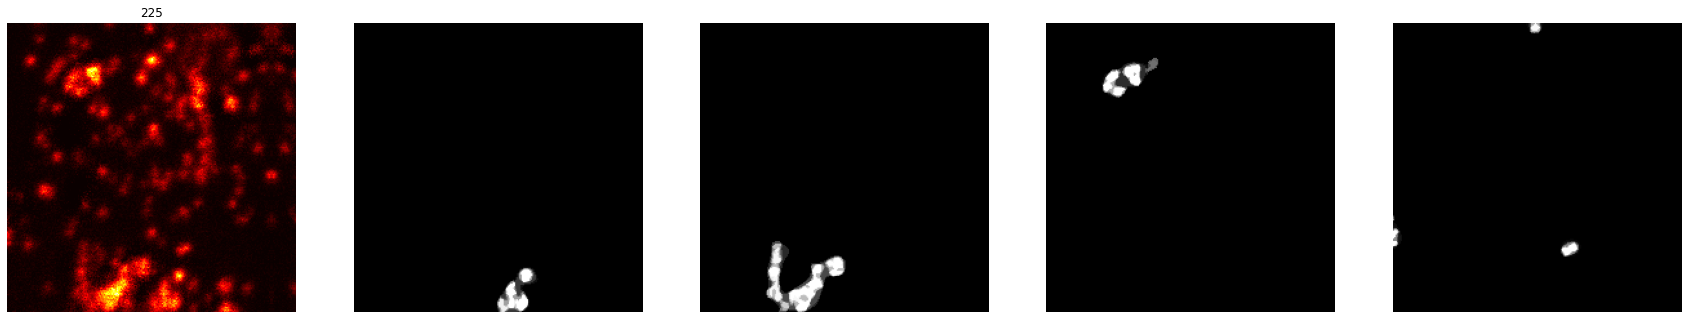

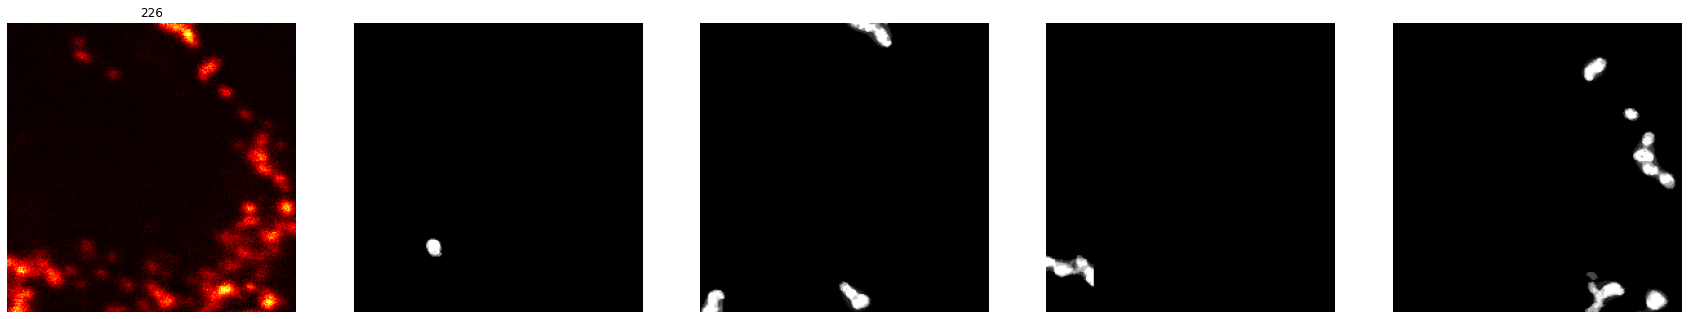

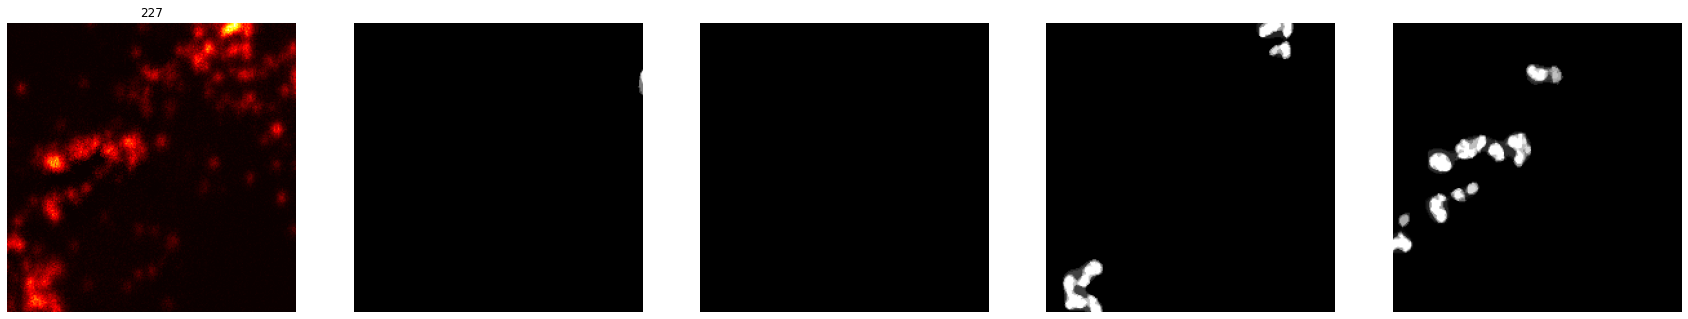

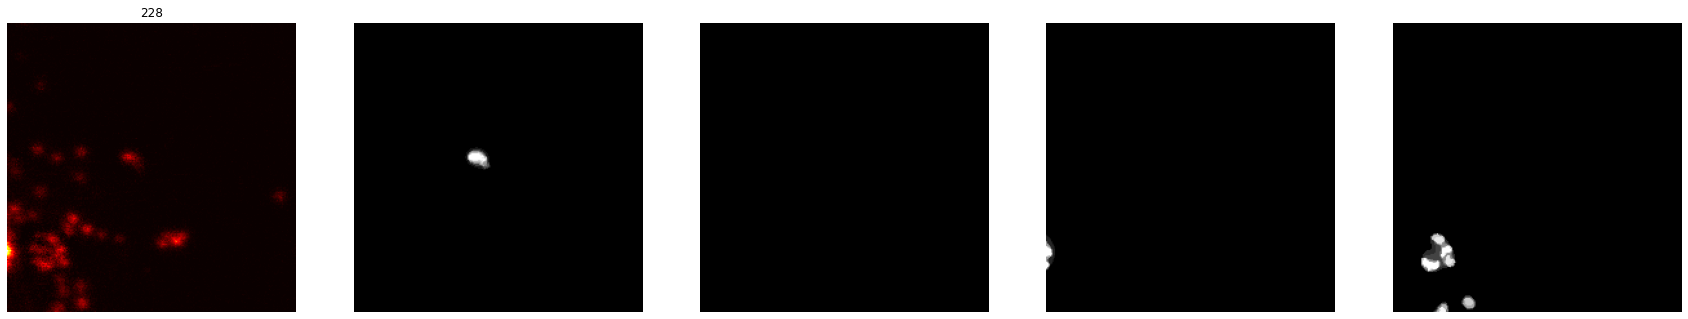

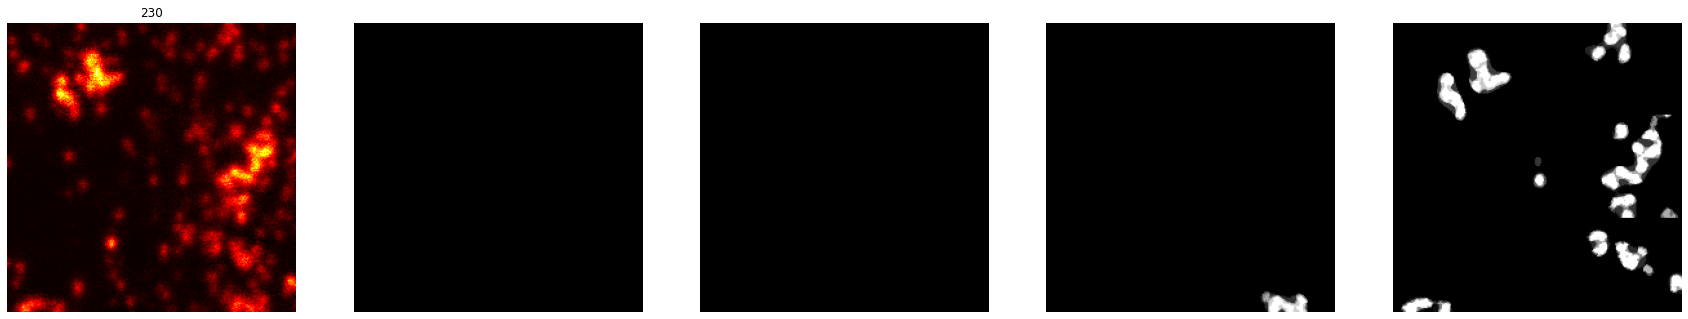

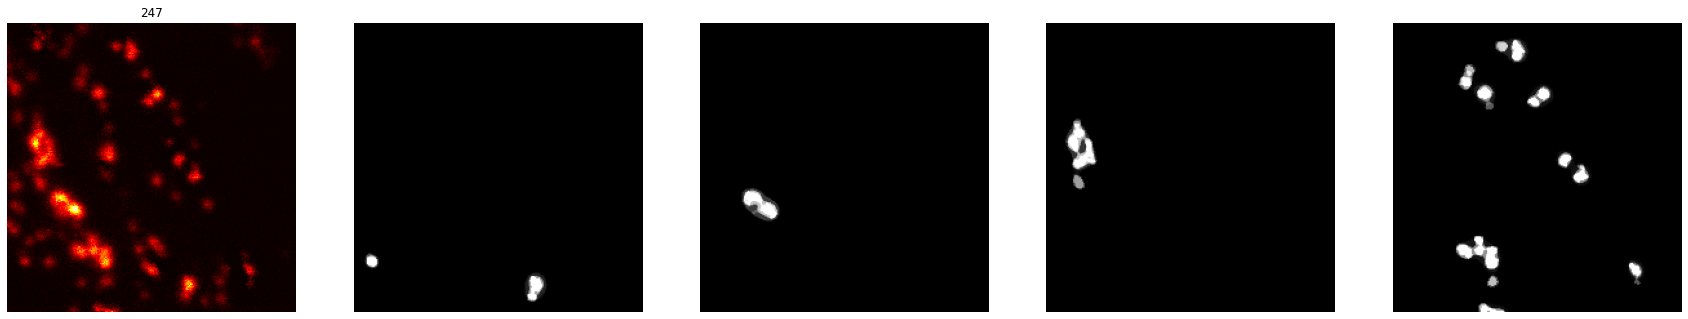

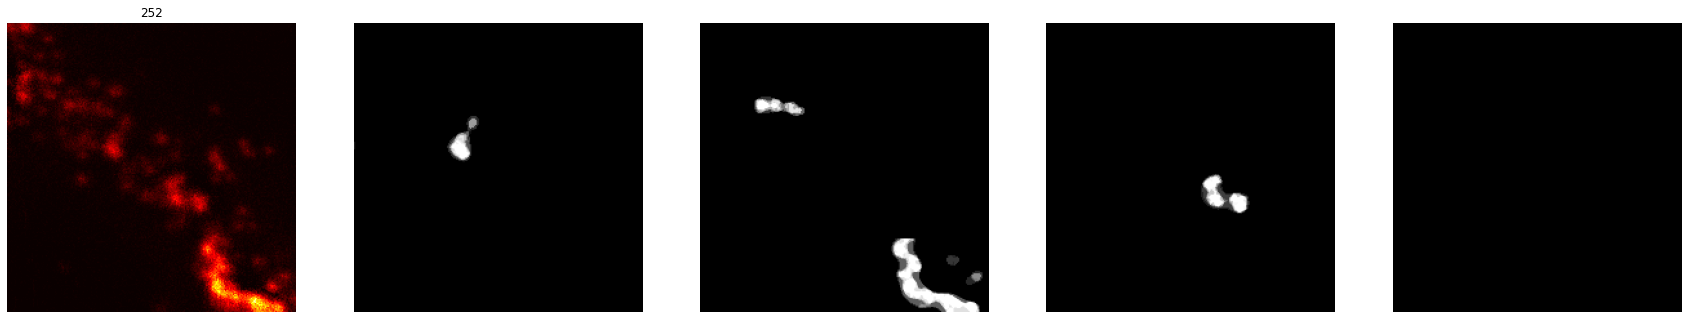

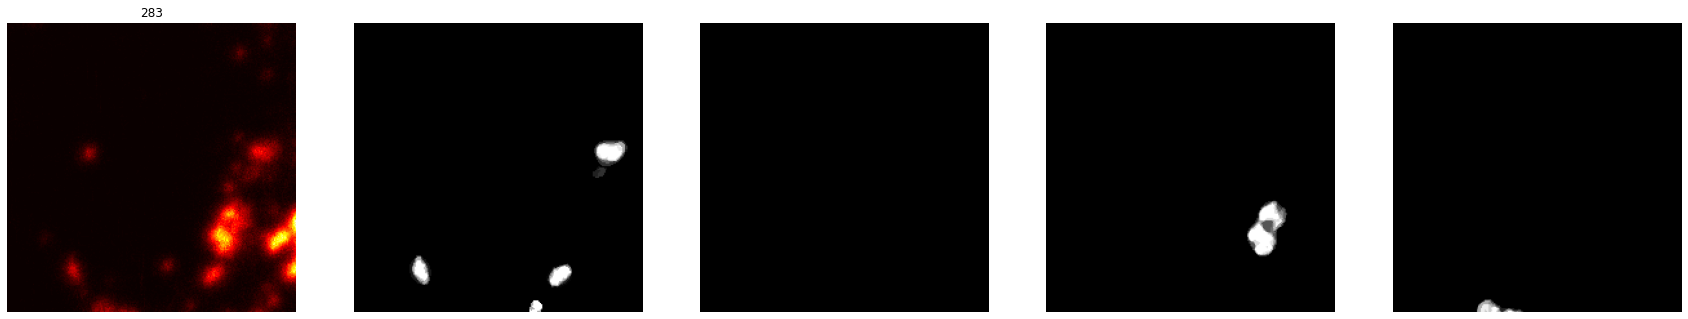

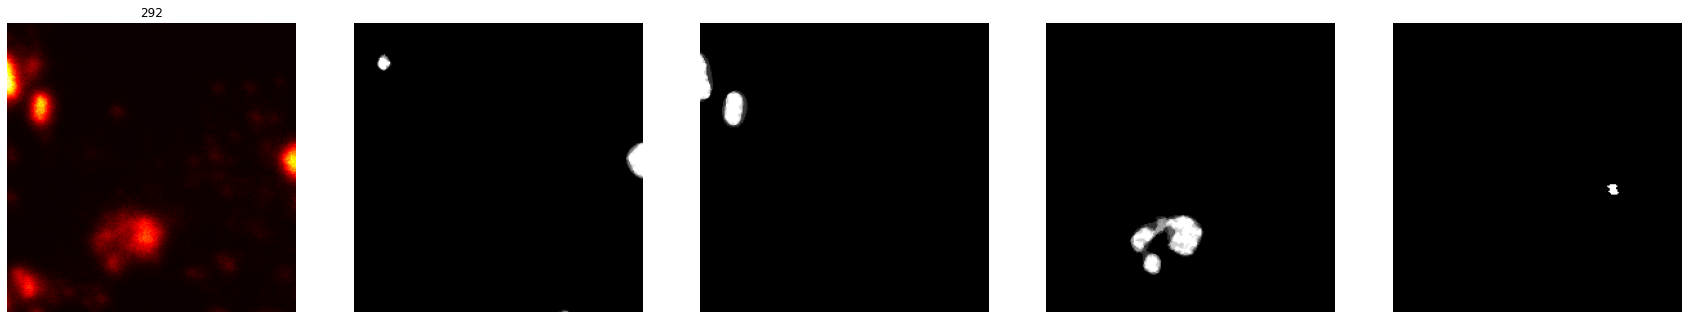

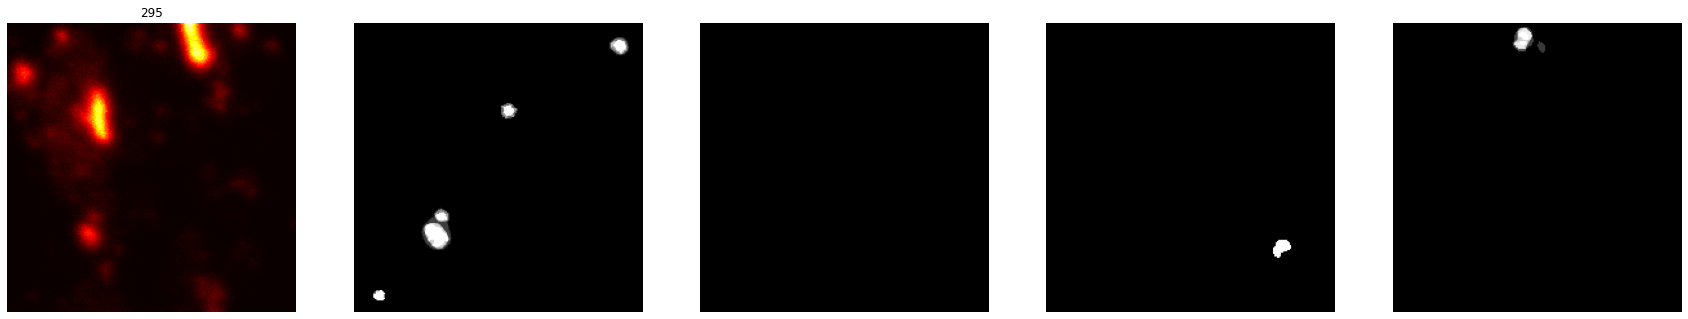

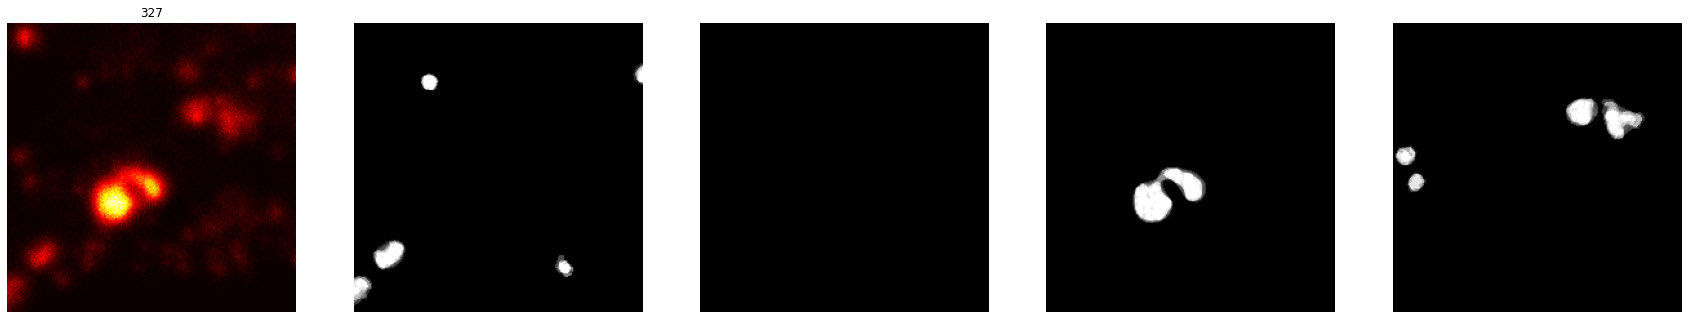

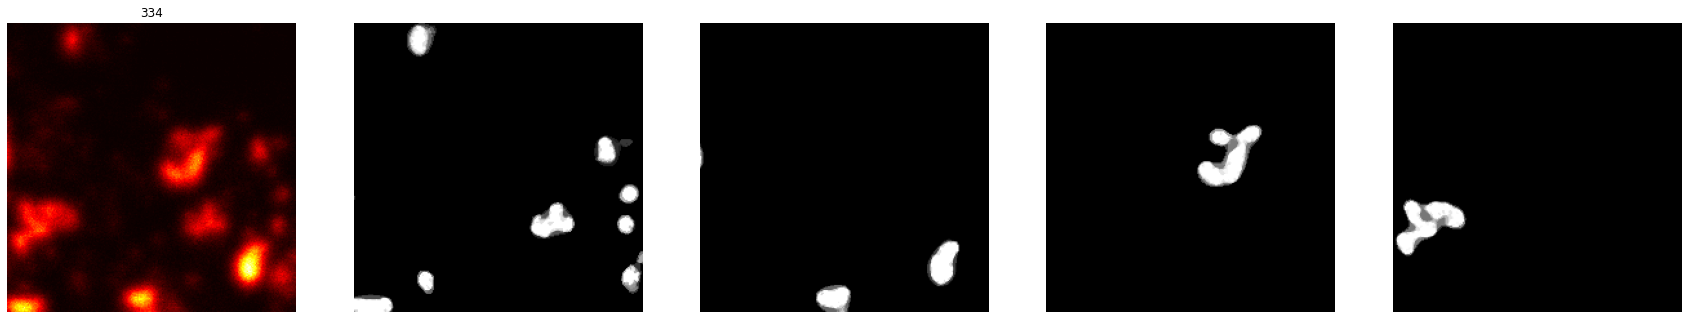

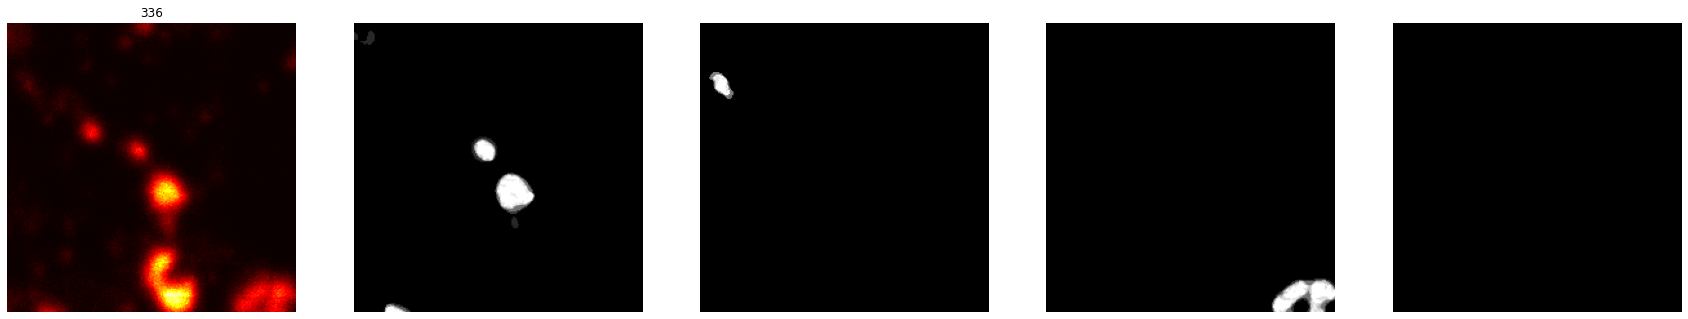

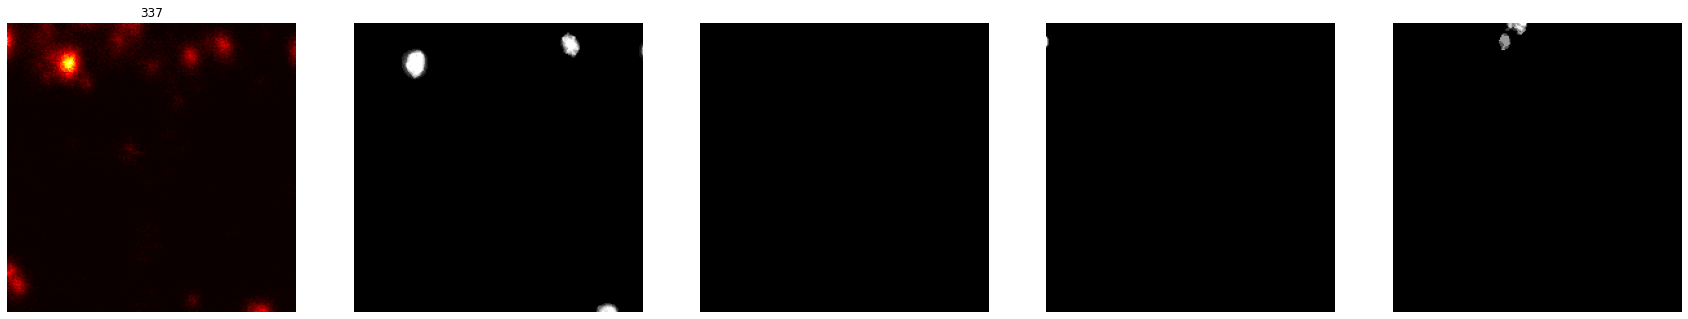

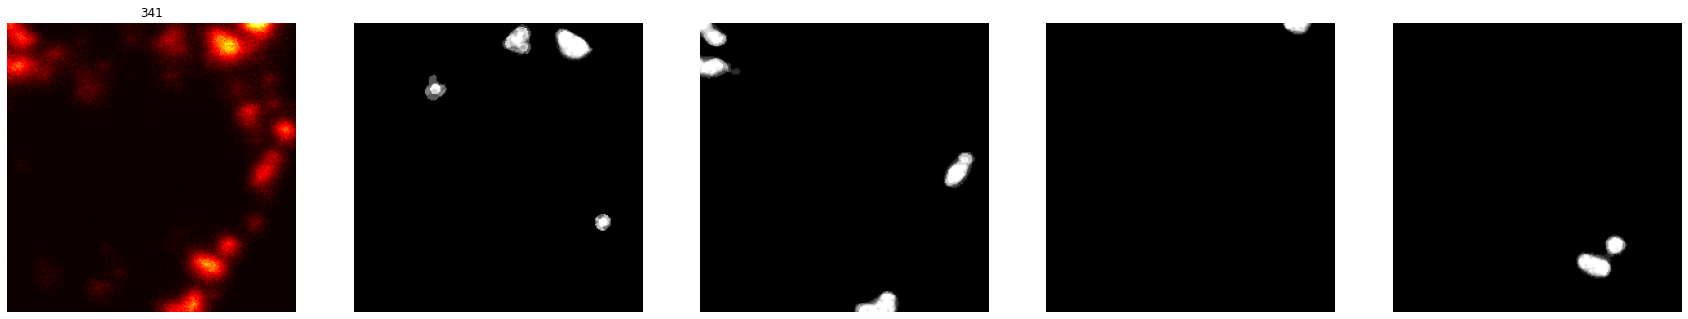

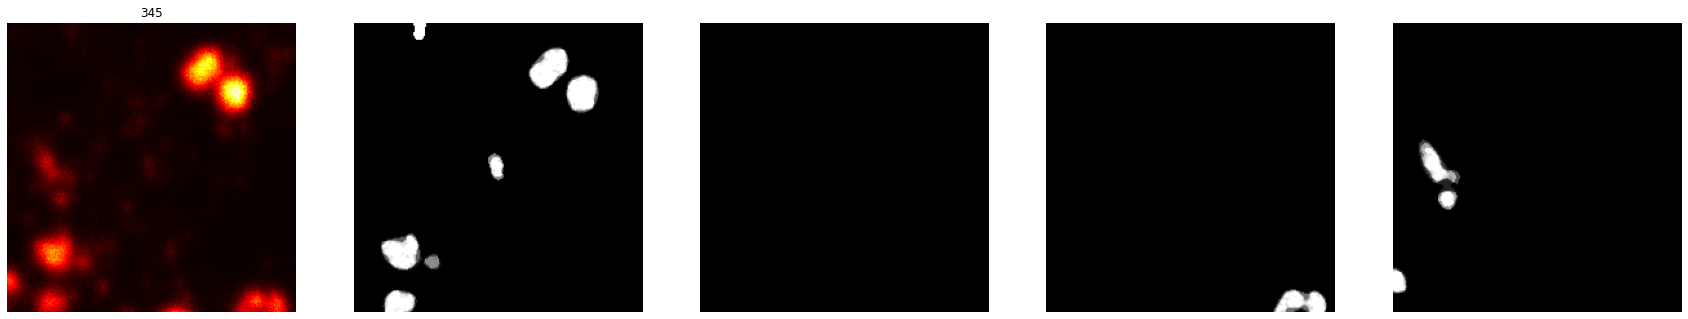

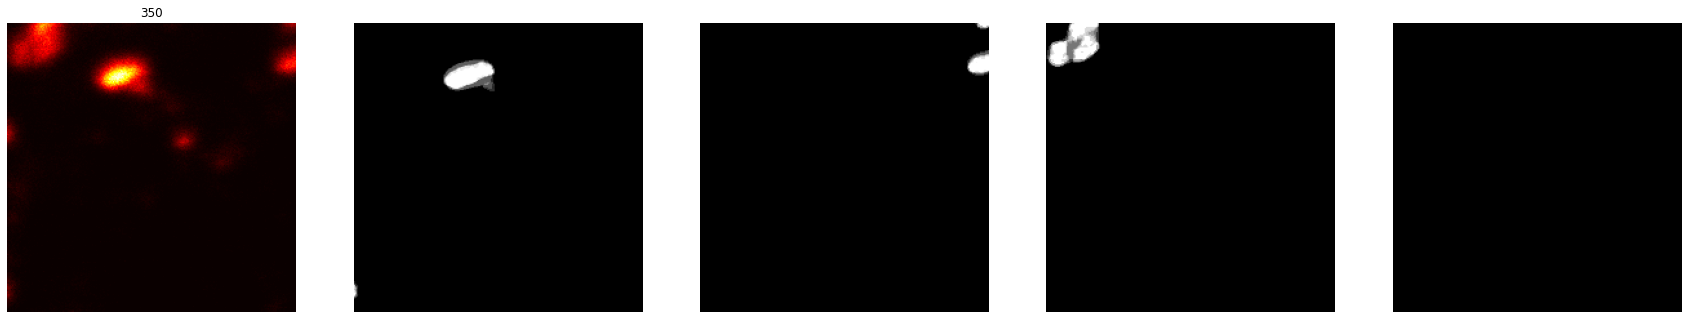

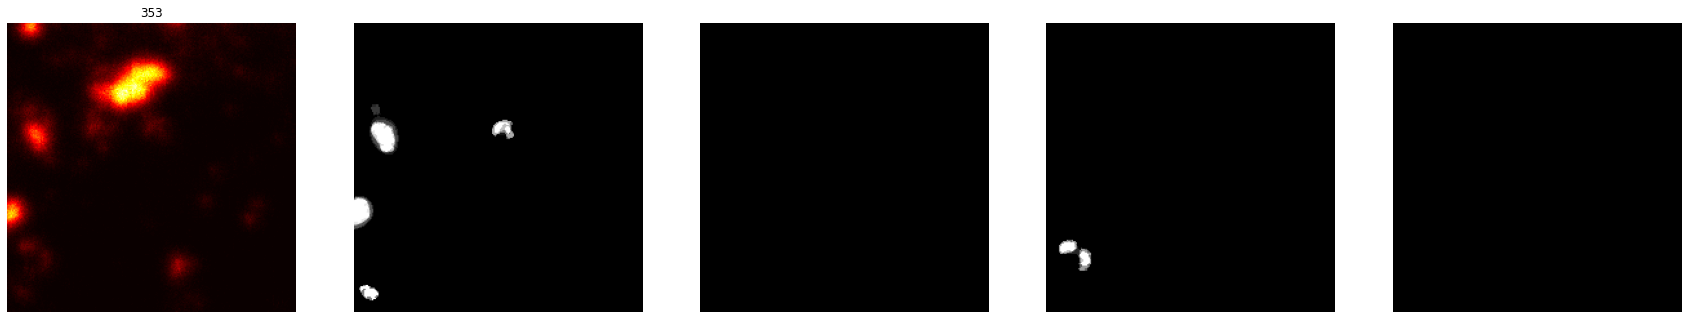

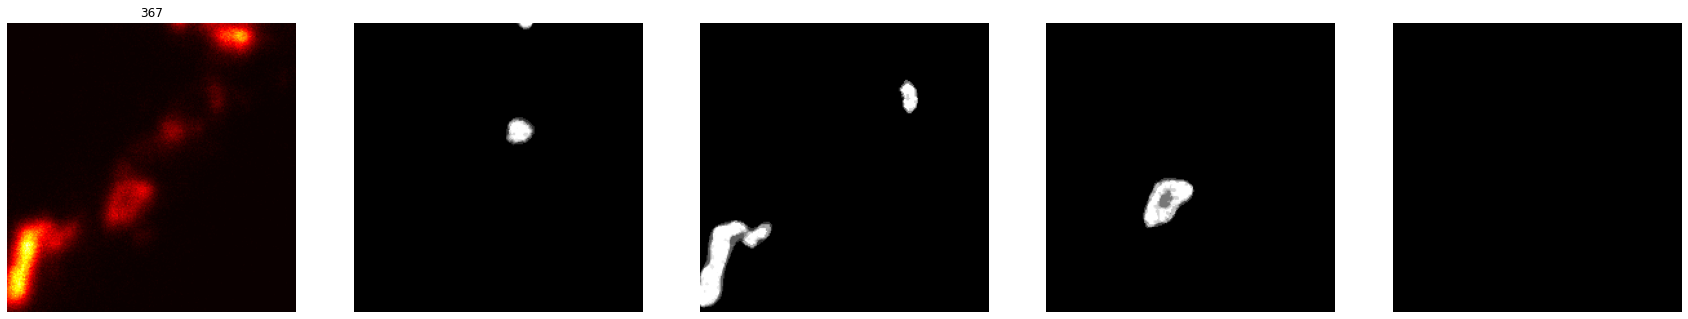

In [30]:
print(len(perforated_indices), len(perforated_coords.keys()), len(perforated_embeddings.keys()))
for index, coords, embedding in zip(perforated_indices, perforated_coords, perforated_embeddings):
    batch = test_dataset[index]
    img, mask = batch 
    img = img.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    coords = perforated_coords[index]
    fig, axs = plt.subplots(1, 5, figsize=(30, 10))
    axs[0].imshow(img, cmap='hot')
    axs[1].imshow(mask[0], cmap='gray')
    axs[2].imshow(mask[1], cmap='gray')
    axs[3].imshow(mask[2], cmap='gray')
    axs[4].imshow(mask[3], cmap='gray')
    for ax in axs:
        ax.axis("off")
    axs[0].set_title(index)
    plt.show()
    # for (y, x) in coords:
    #     fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    #     perf_img = img[y:y+P, x:x+P]
    #     perf_mask = mask[y:y+P, x:x+P]
    #     axs[0].imshow(perf_img, cmap='hot')
    #     axs[1].imshow(perf_mask, cmap='gray')
    #     for ax in axs:
    #         ax.axis("off")
    #     plt.show()
    # break
